In [1]:
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

# system ----
import os
import sys
import csv
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tic
from scipy.integrate import quad
from scipy.interpolate import interp1d 
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

from IPython.display import display, HTML
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

# local ----
localPath = os.path.expanduser("~/")
projPath = os.path.expanduser(localPath+"_projects/researchproject_007/")
sys.path.append(projPath+"modules")
import plot_parameters 

In [2]:
outPath = "/Users/alexandres/_projects/researchproject_007/output/"

# for further checking, we can import Benedikts' Colossus package...
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15');
h0 = cosmo.H0 / 100.0

mmin = 5e7; mmax = 3e11
print(f'mmin: {mmin:.2e} || mmax: {mmax:.2e}')
print(f'mmin/h: {mmin*h0:.2e}, mmax/h: {mmax*h0:.2e}')

mmin: 5.00e+07 || mmax: 3.00e+11
mmin/h: 3.39e+07, mmax/h: 2.03e+11


In [48]:
class BaseAnalysis(object):
    
    def __init__(self, mbounds: float = None, halo_fields=None, *args, **kwargs) -> None:
        """
        """
        
        self.data = dict()
        outPath = "/Users/alexandres/_projects/researchproject_007/output"
        zdef_list = ['z0.000', 'z0.501', 'z1.250', 'z2.000', 'z3.000']
        for zdef in zdef_list:
            # save redshift specific results to sub-dictionary
            zresults = dict()
            fileName = f"{outPath}/projection-{zdef}_.hdf5"
            with h5py.File(fileName, 'r') as h5:
                if halo_fields == None:
                    key_list = list(h5.keys())
                    for key in key_list:
                        zresults[key] = h5[key][()]
                elif isinstance(key_list, list):
                    for key in key_list:
                        zresults[key] = h5[key][()]
                # mbounds given as nested tuple: ("vir", (mmin, mmax))
                if mbounds != None:
                    if isinstance(mbounds[0], str) and isinstance(mbounds[1], tuple):
                        mdef = mbounds[0]
                        mbound = mbounds[1]
                        mass = zresults[f'mass.{mdef}'][()]
                        w = np.where((mbound[0]<mass) & (mass<mbound[1]))[0]
                        for skey, sval in zresults.items():
                            zresults[skey] = sval[w]
            # sub-dictionary saved to parent dictionary
            self.data[zdef] = zresults
   
    def list_avail_redshifts(self) -> str:
        return [key for key,__ in self.data.items()]

    def list_avail_data(self) -> str:
        return [key for key,__ in self.data['z0.000'].items()]
    
    def color_ref_by_redshift(self) -> None:
        results = {}
        
        cmap = matplotlib.cm.get_cmap('magma')
        results['z0.000'] = cmap(0.0)
        results['z0.501'] = cmap(0.25)
        results['z1.250'] = cmap(0.5)
        results['z2.000'] = cmap(0.75)
        results['z3.000'] = cmap(0.875)

        return results
    
    def concatenate_proj_results(self, mdef: str = 'vir') -> float:
        results = dict()
        
        if mdef not in ['vir', '200c']:
            raise ValueError(f"{mdef} is not an accepted parameter.")
            
        zref_list = self.list_avail_redshifts()
        for ind, zref in enumerate(zref_list):
            zresults = dict()
            data = self.data[zref]
            zresults['mass'] = np.concatenate((data[f'mass.{mdef}'], data[f'mass.{mdef}'], data[f'mass.{mdef}']))
            zresults['C.1'] = np.concatenate((data[f'C.1:{mdef}:xyz'], data[f'C.1:{mdef}:yzx'], data[f'C.1:{mdef}:zxy']))
            zresults['M.1kpc'] = np.concatenate((data[f'M.1kpc:{mdef}:xyz'], data[f'M.1kpc:{mdef}:yzx'], data[f'M.1kpc:{mdef}:zxy']))
            zresults['M.enc'] = np.concatenate((data[f'M.enc:{mdef}:xyz'], data[f'M.enc:{mdef}:yzx'], data[f'M.enc:{mdef}:zxy']))
            
            results[zref] = zresults
        return results
    
    def get_statistics(self, xdata: float, ydata: float, nbins: int = 25, 
                             clean_up: bool = True, xbound: float = None,
                             *args, **kwargs) -> float:
        """
        """
        results = dict()
        
        """
        if zref not in self.list_avail_redshifts():
            raise KeyError("`{zref}` not available, please specify refrence redshift from list: {self.list_avail_redshifts()}.")   
        if not proj_res:
            if xdata and ydata not in self.list_avail_data():
                raise KeyError("`{xdata}` or `{ydata}` not available as a data value.")
            xdata_val = self.data[zref][xdata]
            ydata_val = self.data[zref][ydata]
        else:
            proj_conc = self.concatenate_proj_results(mdef=proj_mdef)[zref]
            xdata_val = proj[xdata]
            ydata_val = proj[ydata]
        """
        
        if xbound == None:    
            power_arr = np.linspace(np.log10(xdata.min()), np.log10(xdata.max()), nbins)
        elif isinstance(xbound, tuple):
            power_arr = np.linspace(np.log10(xbound[0]), np.log10(xbound[1]), nbins)         
        x_arr = 10 ** power_arr
        delta = x_arr[1] - x_arr[0]
        idx = np.digitize(xdata, x_arr)
        
        results['x.bins'] = x_arr - delta/2.0
        results['y.median'], results['y.average'] = np.zeros(nbins), np.zeros(nbins)
        results['y.1sigma.upper'], results['y.1sigma.lower'] = np.zeros(nbins), np.zeros(nbins)
        results['y.2sigma.upper'], results['y.2sigma.lower'] = np.zeros(nbins), np.zeros(nbins)
        results['y.3sigma.upper'], results['y.3sigma.lower'] = np.zeros(nbins), np.zeros(nbins)

        for ind, x in enumerate(x_arr):
            yi = ydata[idx == ind]
            percentage = [0.68, 0.90, 0.99]
            try:
                yis = np.sort(yi)
                results['y.median'][ind] += yis[int(0.50*yi.shape[0])]
                results['y.average'][ind] += np.average(yi)
                for ip, numb in enumerate(percentage):
                    results[f'y.{ip+1}sigma.upper'][ind] = yis[round(numb*yi.shape[0])]
                    results[f'y.{ip+1}sigma.lower'][ind] = yis[round((1.0-numb)*yi.shape[0])]
            except IndexError:
                pass
            
        if clean_up:
            cond1 = results['y.median'] != 0
            cond2 = results['x.bins'] >= xdata.min()
            w = np.where(cond1 & cond2)[0]
            for skey, sval in results.items():
                results[skey] = sval[w]
        
        return results
                
    def plot_stats_scatter(self, stats, axs, color):
        axs.scatter(stats['x.bins'], stats['y.median'], color=color, s=15)
        for i in range(stats['x.bins'].shape[0]):
            xerr = np.linspace(stats['x.bins'][i], stats['x.bins'][i])
            yerr = np.linspace(stats['y.1sigma.lower'][i], stats['y.1sigma.upper'][i])
            hlen = 10**np.linspace(np.log10(xerr*0.95), np.log10(xerr/0.95)) 
            yerr1 = np.linspace(stats['y.1sigma.lower'][i],stats['y.1sigma.lower'][i])
            yerr2 = np.linspace(stats['y.1sigma.upper'][i], stats['y.1sigma.upper'][i])
            axs.plot(xerr, yerr, color=color, lw=0.75)
            axs.plot(hlen, yerr1, color=color, lw=0.75)
            axs.plot(hlen, yerr2, color=color, lw=0.75)
            
    def plot_stats_line(self, data, axs, color):
        axs.plot(data['x.bins'], data['y.median'], color=color, lw=1.25)
        axs.fill_between(data['x.bins'], 
                         data['y.1sigma.lower'], 
                         data['y.1sigma.upper'], 
                         facecolor=color, edgecolor="None", alpha=0.25)   

In [50]:
ba = BaseAnalysis(mbounds=('vir', (1e8*h0, 3e11*h0)))

ba.data['z0.000']['C.1:200c:xyz']
ba.concatenate_proj_results(mdef='vir')['z0.000']['mass']

ba.list_avail_data()

['C.1:200c:xyz',
 'C.1:200c:yzx',
 'C.1:200c:zxy',
 'C.1:vir:xyz',
 'C.1:vir:yzx',
 'C.1:vir:zxy',
 'E.1:200c:xyz',
 'E.1:200c:yzx',
 'E.1:200c:zxy',
 'E.1:vir:xyz',
 'E.1:vir:yzx',
 'E.1:vir:zxy',
 'M.1kpc:200c:xyz',
 'M.1kpc:200c:yzx',
 'M.1kpc:200c:zxy',
 'M.1kpc:vir:xyz',
 'M.1kpc:vir:yzx',
 'M.1kpc:vir:zxy',
 'M.enc:200c:xyz',
 'M.enc:200c:yzx',
 'M.enc:200c:zxy',
 'M.enc:vir:xyz',
 'M.enc:vir:yzx',
 'M.enc:vir:zxy',
 'R.1:200c:xyz',
 'R.1:200c:yzx',
 'R.1:200c:zxy',
 'R.1:vir:xyz',
 'R.1:vir:yzx',
 'R.1:vir:zxy',
 'ein:alpha',
 'ein:c.200c',
 'ein:c.vir',
 'ein:r.2',
 'ein:rho.2',
 'mass.200c',
 'mass.vir',
 'nfw:c.200c',
 'nfw:c.vir',
 'nfw:r.s',
 'nfw:rho.s',
 'rad.200c',
 'rad.pow',
 'rad.vir']

---
# Power-Law analysis

In [51]:
class RegressionFits(BaseAnalysis):
    
    def __init__(self, mbounds: float = None, halo_fields=None, *args, **kwargs) -> None:
        super().__init__(mbounds, halo_fields, *args, **kwargs)
        
    def power_law(self, M: float, a: float, b: float):
        norm = 1e10 # Msol/h
        d = M/norm
        return 10**a * d**b
    
    def log10_power_law(self, log10M: float, a: float, b: float):
        norm = np.log10(1e10) # Msol/h
        d = log10M - norm
        return a + b*d
    
    def a_fit(self, z: float, a1: float, a2:float, a3: float, a4: float, a5: float, *args, **kwargs):
        return a1 + (a2)*np.exp(a4*np.power(z,a5)) 
    
    def b_fit(self, z: float, b1: float, b2: float, *args, **kwargs):
        return b1 + b2*z
    
    def power_law_fit(self, xdata: float, ydata: float, func=None, guess: float=None) -> float:
        """
        """        
        from scipy.optimize import curve_fit
        
        if func == None:
            func = self.log10_power_law
            xdata = np.log10(xdata)
            ydata = np.log10(ydata)
        
        popt, __ = curve_fit(f=func,
                             xdata=xdata,
                             ydata=ydata,
                             p0=guess,
                             maxfev=2400)

        return popt

    
    def power_law_fit_all_redshifts(self, xdata: float, ydata: float, func=None) -> float:
        """
        """
        results = dict()
  
        from scipy.optimize import curve_fit
        
        zref_list = self.list_avail_redshifts()
        npoints = len(zref_list)
        results['z.vals'] = np.zeros(npoints)
        results['a.vals'] = np.zeros(npoints)
        results['b.vals'] = np.zeros(npoints)
        
        if func == None:
            func = self.log10_power_law
        
        # fit whatever is given as xdata and ydata to power law
        for ind, zref in enumerate(zref_list):
            zval = np.float64(zref[1:])
            results['z.vals'][ind] += zval
            
            zdata = self.data[zref]
            
            popt, __ = curve_fit(f=self.log10_power_law,
                                 xdata=np.log10(zdata[xdata]),
                                 ydata=np.log10(zdata[ydata]))
            results['a.vals'][ind] += popt[0]
            results['b.vals'][ind] += popt[1]
            
        # fit resulting a and b values as functions of redshift z
        aopt, __ = curve_fit(f=self.a_fit,
                              xdata=results['z.vals'],
                              ydata=results['a.vals'],
                              p0=(0.655, 0.633, 0., -0.440, 1.146)
                          )
        bopt, __ = curve_fit(f=self.b_fit,
                              xdata=results['z.vals'],
                              ydata=results['b.vals'],
                          )
        results['a.fit'] = aopt
        results['b.fit'] = bopt
        
        return results

---
### Median Projected Concentration-mass relation

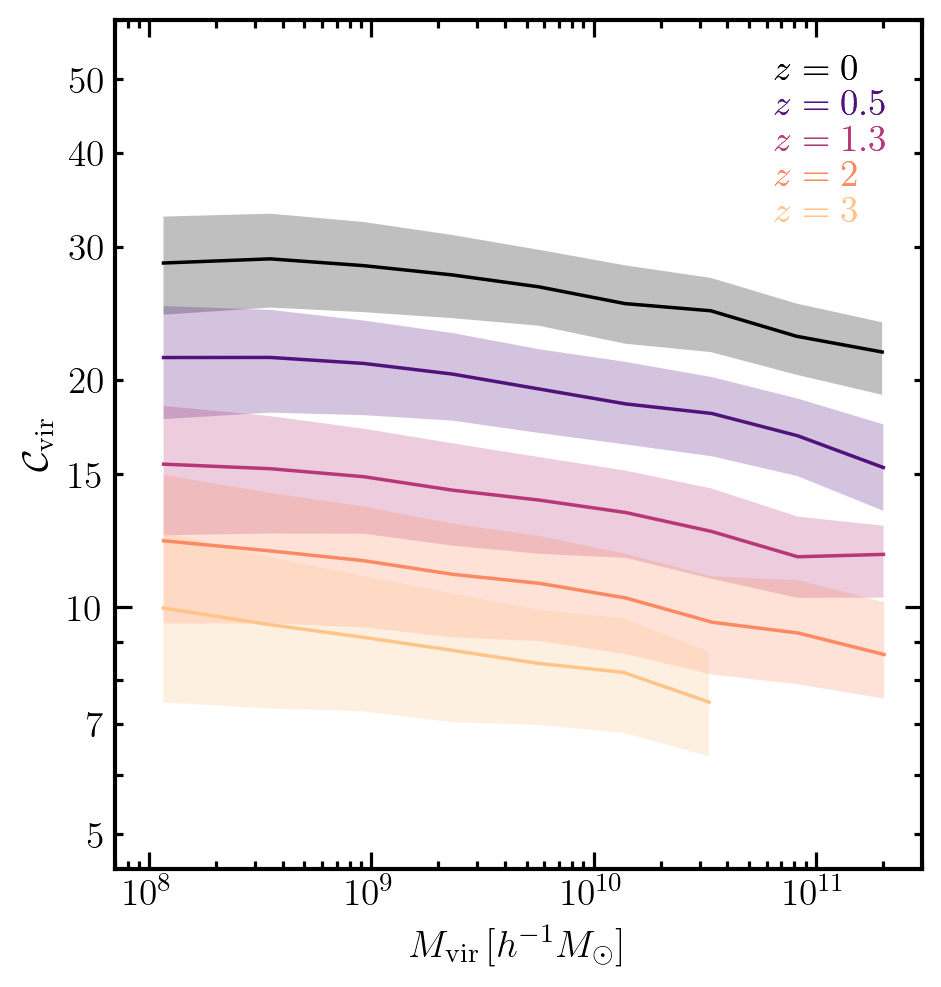

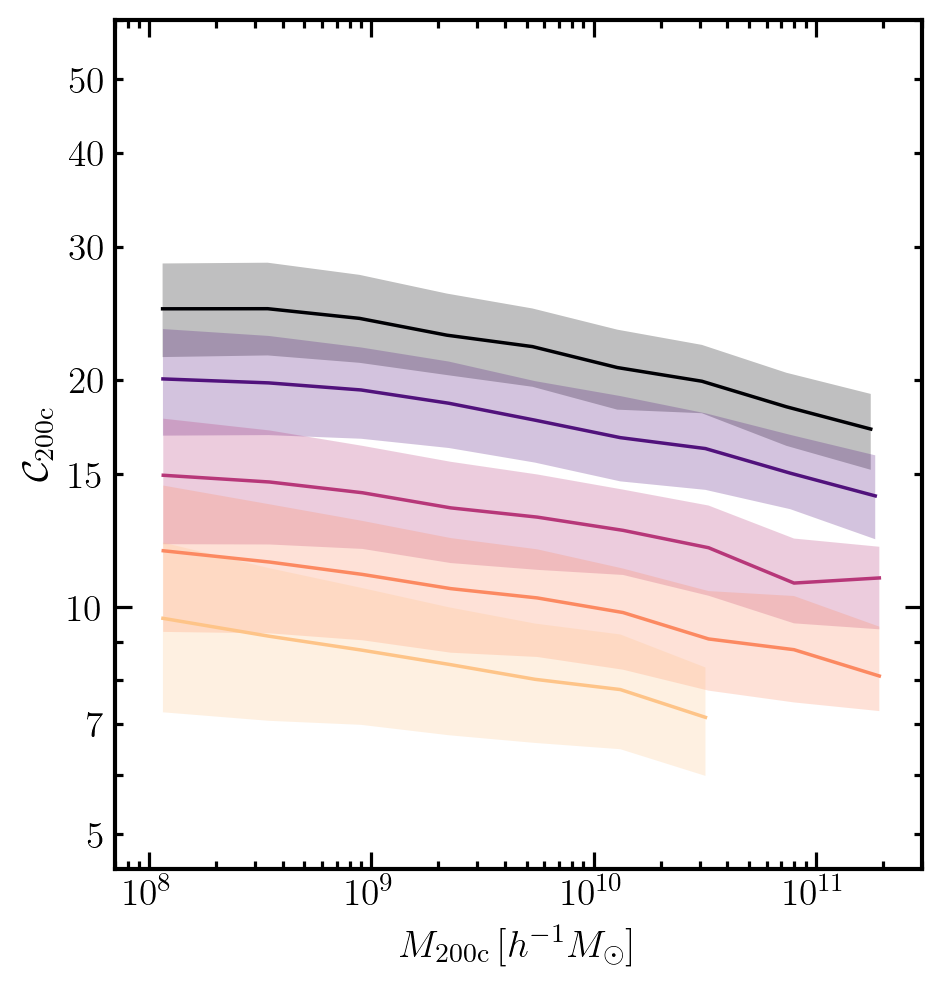

In [77]:
# predefined parameters to pass
mdefs = ['vir', '200c']
mmin, mmax = 1e8*h0, 3e11*h0
nbins = 10

# parse through every key function and plot those results
for mdef in mdefs:
    
    # initialize plot
    fig, ax = plt.subplots(figsize=(6.25/1.2, 6.75/1.2), dpi=100)

    ax.xaxis.set_tick_params(direction='in', which='both'); ax.yaxis.set_tick_params(direction='in', which='both')
    ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both')
    ax.set_xlabel(r'$M_{\rm %s}\, [h^{-1}M_{\odot}]$' % (mdef)); ax.set_ylabel(r'$\mathcal{C}_{\rm %s}$' % (mdef))
    ax.set_xscale('log'); ax.set_yscale('log');
    ax.set_xlim(7e7,3e11); ax.set_ylim(4.5,60)

    ax.set_yticks([5,6,7,8,9,15,20,30,40,50,60],minor=True)
    ax.set_yticklabels([r'$5$','',r'$7$','','',r'$15$',r'$20$',r'$30$',r'$40$','$50$',''], fontsize=13.5,minor=True)
    ax.set_yticks([10])
    ax.set_yticklabels([r'$10$'], fontsize=13.5)
    
    # -----------------------------------------------------------------------------------------

    cmap = matplotlib.cm.get_cmap('magma')
    color0=cmap(0.0)
    color05=cmap(0.25)
    color1=cmap(0.5)
    color2=cmap(0.75)
    color3=cmap(0.875)
    
    if mdef == 'vir':
        from matplotlib.patches import Rectangle
        empty = Rectangle((0,0), 0, 0, alpha=0.0)
        sim_leg = ax.legend([empty]*7,
                        [r'$z = 0$',
                        r'$z = 0.5$',
                        r'$z = 1.3$',
                        r'$z = 2$',
                        r'$z = 3$'],
                       loc="upper right",frameon=False,ncol=1,
                       fontsize=13.5,handlelength=0,handletextpad=0,labelspacing=0.05)
        sim_leg.get_texts()[0].set_color(color0)
        sim_leg.get_texts()[1].set_color(color05)
        sim_leg.get_texts()[2].set_color(color1)
        sim_leg.get_texts()[3].set_color(color2)
        sim_leg.get_texts()[4].set_color(color3)
        ax.add_artist(sim_leg)
        
    # -----------------------------------------------------------------------------------------
    
    ba = BaseAnalysis()
    for ind, zref in enumerate(ba.list_avail_redshifts()):

        # load relavent data
        proj_res = ba.concatenate_proj_results(mdef=mdef)[zref]
        xdata, ydata = proj_res['mass']*h0, proj_res['C.1']
        mask = (mmin < xdata) & (xdata < mmax)
        
        # produce bin statistics
        stats = ba.get_statistics(xdata=xdata[mask], ydata=ydata[mask],
                                  nbins=nbins, 
                                  clean_up=True)
        
        if zref == 'z3.000':
            mask = stats['x.bins'] < 5e10
            for skey, sval in stats.items():
                stats[skey] = sval[mask] 
                
        
        color = ba.color_ref_by_redshift()[zref]
        ba.plot_stats_line(data=stats, axs=ax, color=color)

---

### $M_{\Delta}$ and $\mathcal{M}_{\rm eff}$ relation:
\begin{align}
    \mathcal{M}_{\rm eff} = 10^{a}\, \left( \frac{M_{\Delta}}{10^{10}\, h^{-1}M_{\odot}} \right)^{b}\, h^{-1}M_{\odot}
\end{align}

In [60]:
ba = BaseAnalysis()

m1 = ba.data['z0.000']['M.enc:vir:xyz']
m2 = ba.data['z0.000']['mass.vir']
print(np.average(m1/m2))

1.075952173453193


Parameters: (a, b) = (10.030, 0.997)


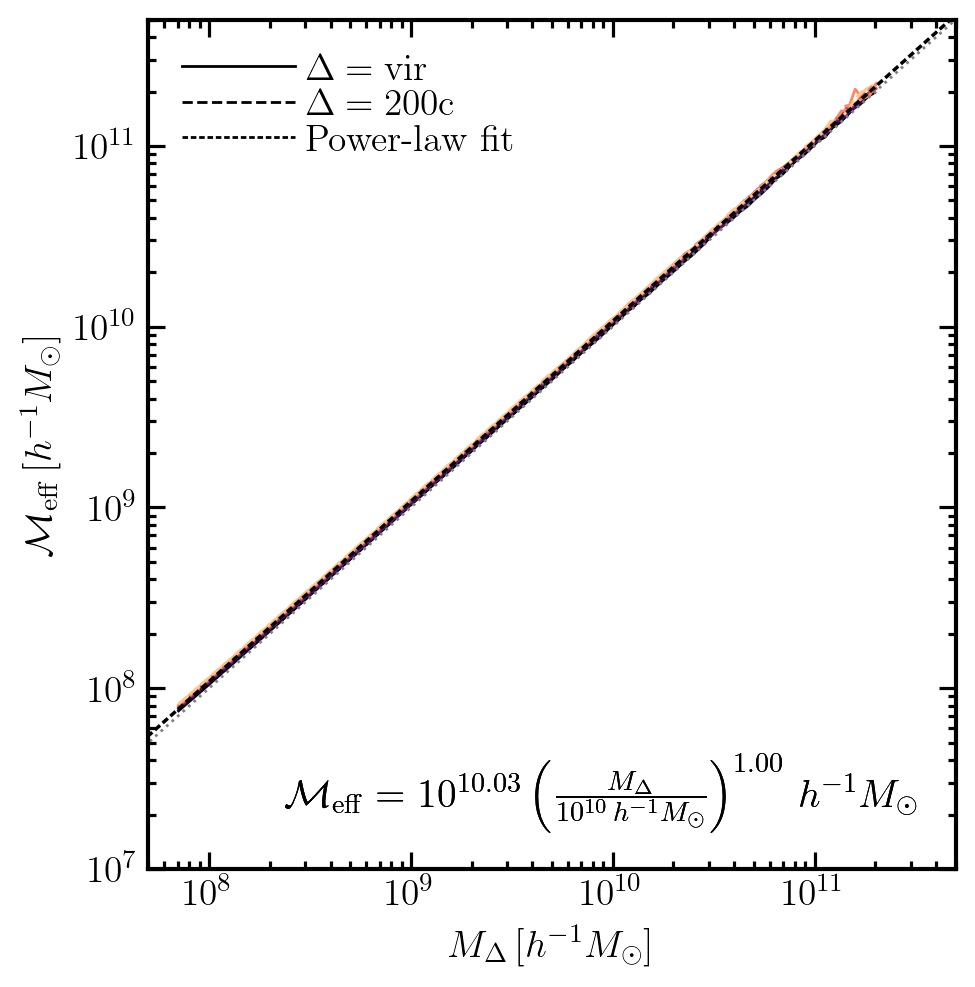

In [69]:
# initialize plot
fig, ax = plt.subplots(figsize=(6.25/1.2, 6.75/1.2), dpi=100)

ax.xaxis.set_tick_params(direction='in', which='both'); ax.yaxis.set_tick_params(direction='in', which='both')
ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both')
ax.set_xlabel(r'$M_{\Delta}\, [h^{-1}M_{\odot}]$'); ax.set_ylabel(r'$\mathcal{M}_{\rm eff}\, [h^{-1}M_{\odot}]$')
ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim(5e7, 5e11); ax.set_ylim(1e7, 5e11)

# predefined parameters to pass
mdefs = ['vir', '200c']
mmin, mmax = 1e8*h0, 3e11*h0
nbins = 100

# parse through every key function and plot those results
xvals = [] 
yvals = []
for mdef in mdefs:
    rf = RegressionFits()
    for ind, zref in enumerate(rf.list_avail_redshifts()):

        # load relavent data
        proj_res = ba.concatenate_proj_results(mdef=mdef)[zref]
        xdata, ydata = proj_res['mass']*h0, proj_res['M.enc']*h0
        mask = (mmin < xdata) & (xdata < mmax)
        
        # produce bin statistics
        stats = ba.get_statistics(xdata=xdata[mask], ydata=ydata[mask],
                                  nbins=nbins, 
                                  clean_up=True)
        if mdef == 'vir':
            ls = '-'
        elif mdef == '200c':
            ls = '--'
            
        color = ba.color_ref_by_redshift()[zref]
        ax.plot(stats['x.bins'], stats['y.median'], color=color, lw=1.0, ls=ls)
        xvals.append(stats['x.bins'])
        yvals.append(stats['y.median'])

# power law fit everything
xvals = np.concatenate(xvals)
yvals = np.concatenate(yvals)
rf = RegressionFits()
popt = rf.power_law_fit(xdata=xvals, ydata=yvals)
print(f"Parameters: (a, b) = ({popt[0]:.3f}, {popt[1]:.3f})")

xarr = 10.0 ** np.linspace(7.0, 12.0)
ax.plot(xarr , rf.power_law(xarr, *popt), color='k', lw=1.25, dashes=[2, 1])

# plot legend

ax.plot([0, 0], [0, 0], ls='-', lw=1.0, color='k', label=r"$\Delta = \rm vir$")
ax.plot([0, 0], [0, 0], ls='--', lw=1.0, color='k', label=r"$\Delta = \rm 200c$")
ax.plot([0, 0], [0, 0], dashes=[2, 1], lw=1.0, color='k', label=r"$\rm Power$-$\rm law\ fit$")
line_leg = ax.legend(frameon=False, loc='upper left', fontsize=13.5, handlelength=3, handletextpad=0.3, labelspacing=0.05)
ax.add_artist(line_leg)

from matplotlib.patches import Rectangle
empty = Rectangle((0,0), 0, 0, alpha=0.0)
a_str = r'$\mathcal{M}_{\rm eff} = 10^{%.2f}\left(\frac{M_{\Delta}}{10^{10}\, h^{-1}M_{\odot}}\right)^{%.2f}\, h^{-1}M_{\odot}$' % (popt[0], popt[1])
leg = ax.legend([empty], [a_str], loc="lower right", frameon=False, fontsize=14.5, handlelength=0, handletextpad=0)
leg.get_texts()[0].set_color('k'); ax.add_artist(leg)

ax.plot(np.linspace(1e7, 1e12), np.linspace(1e7, 1e12), color='gray', ls=':', lw=1.0)

plt.show()

---
### Projected Concentration-Mass relation $M_{\Delta}$ and $\mathcal{C}_{\Delta}$ [power-law]

Assuming basic power-law:
\begin{align}
    \mathcal{C}_{\Delta} = 10^{\mathcal{A}(z)}\, \left( \frac{M_{\Delta}}{10^{10}\, h^{-1}M_{\odot}} \right)^{\mathcal{B}(z)} \, ,
\end{align}

where the free-parameters $\mathcal{A}$ and $\mathcal{B}$ evolve with redshift $z$:


/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


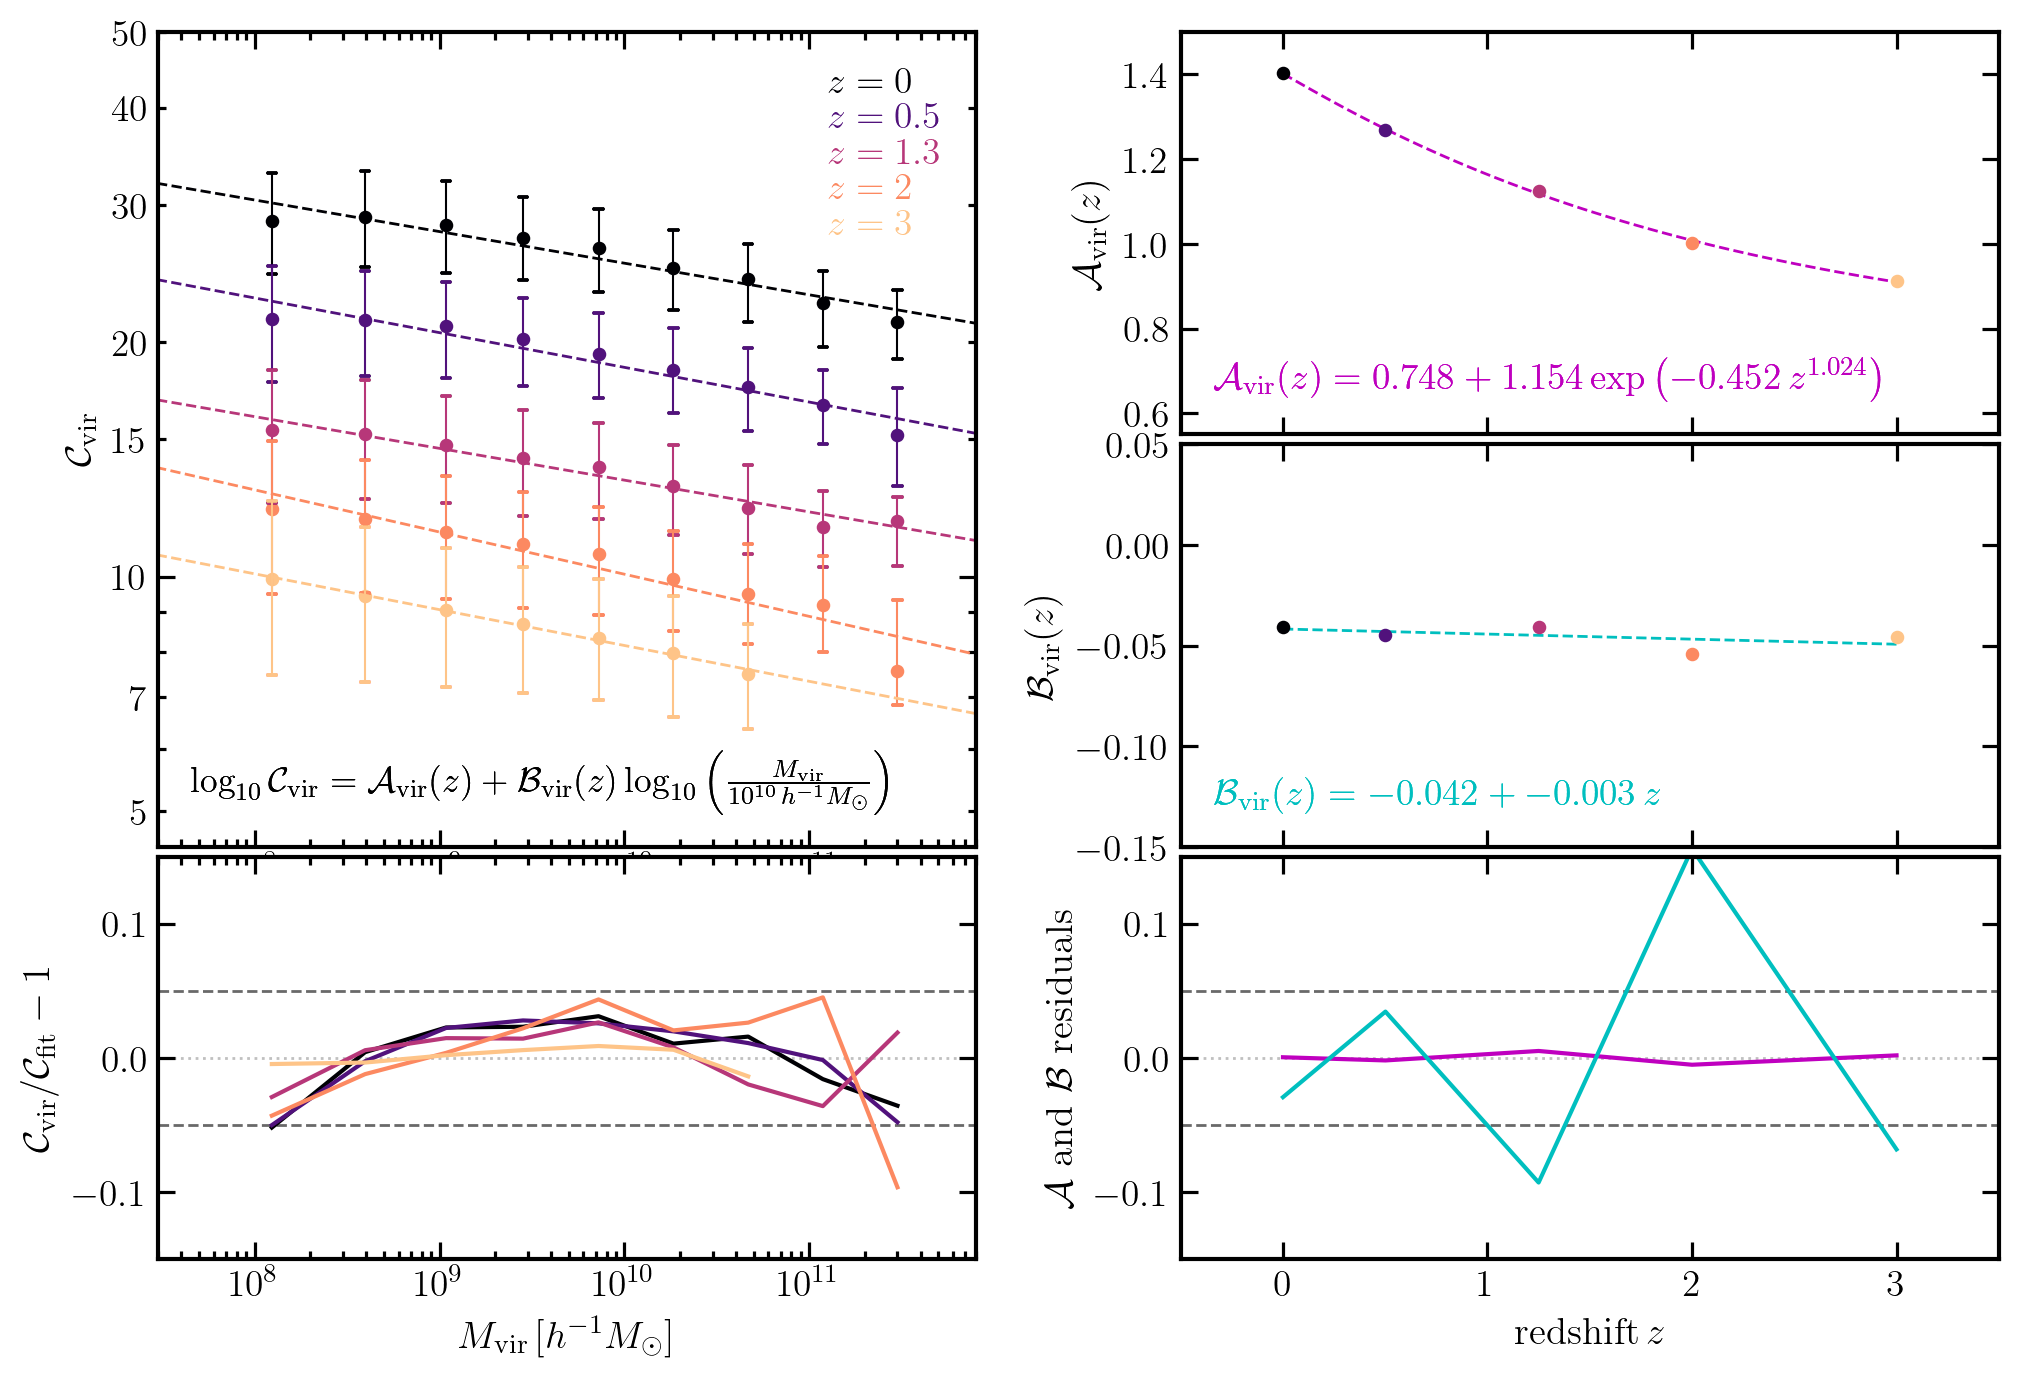

/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


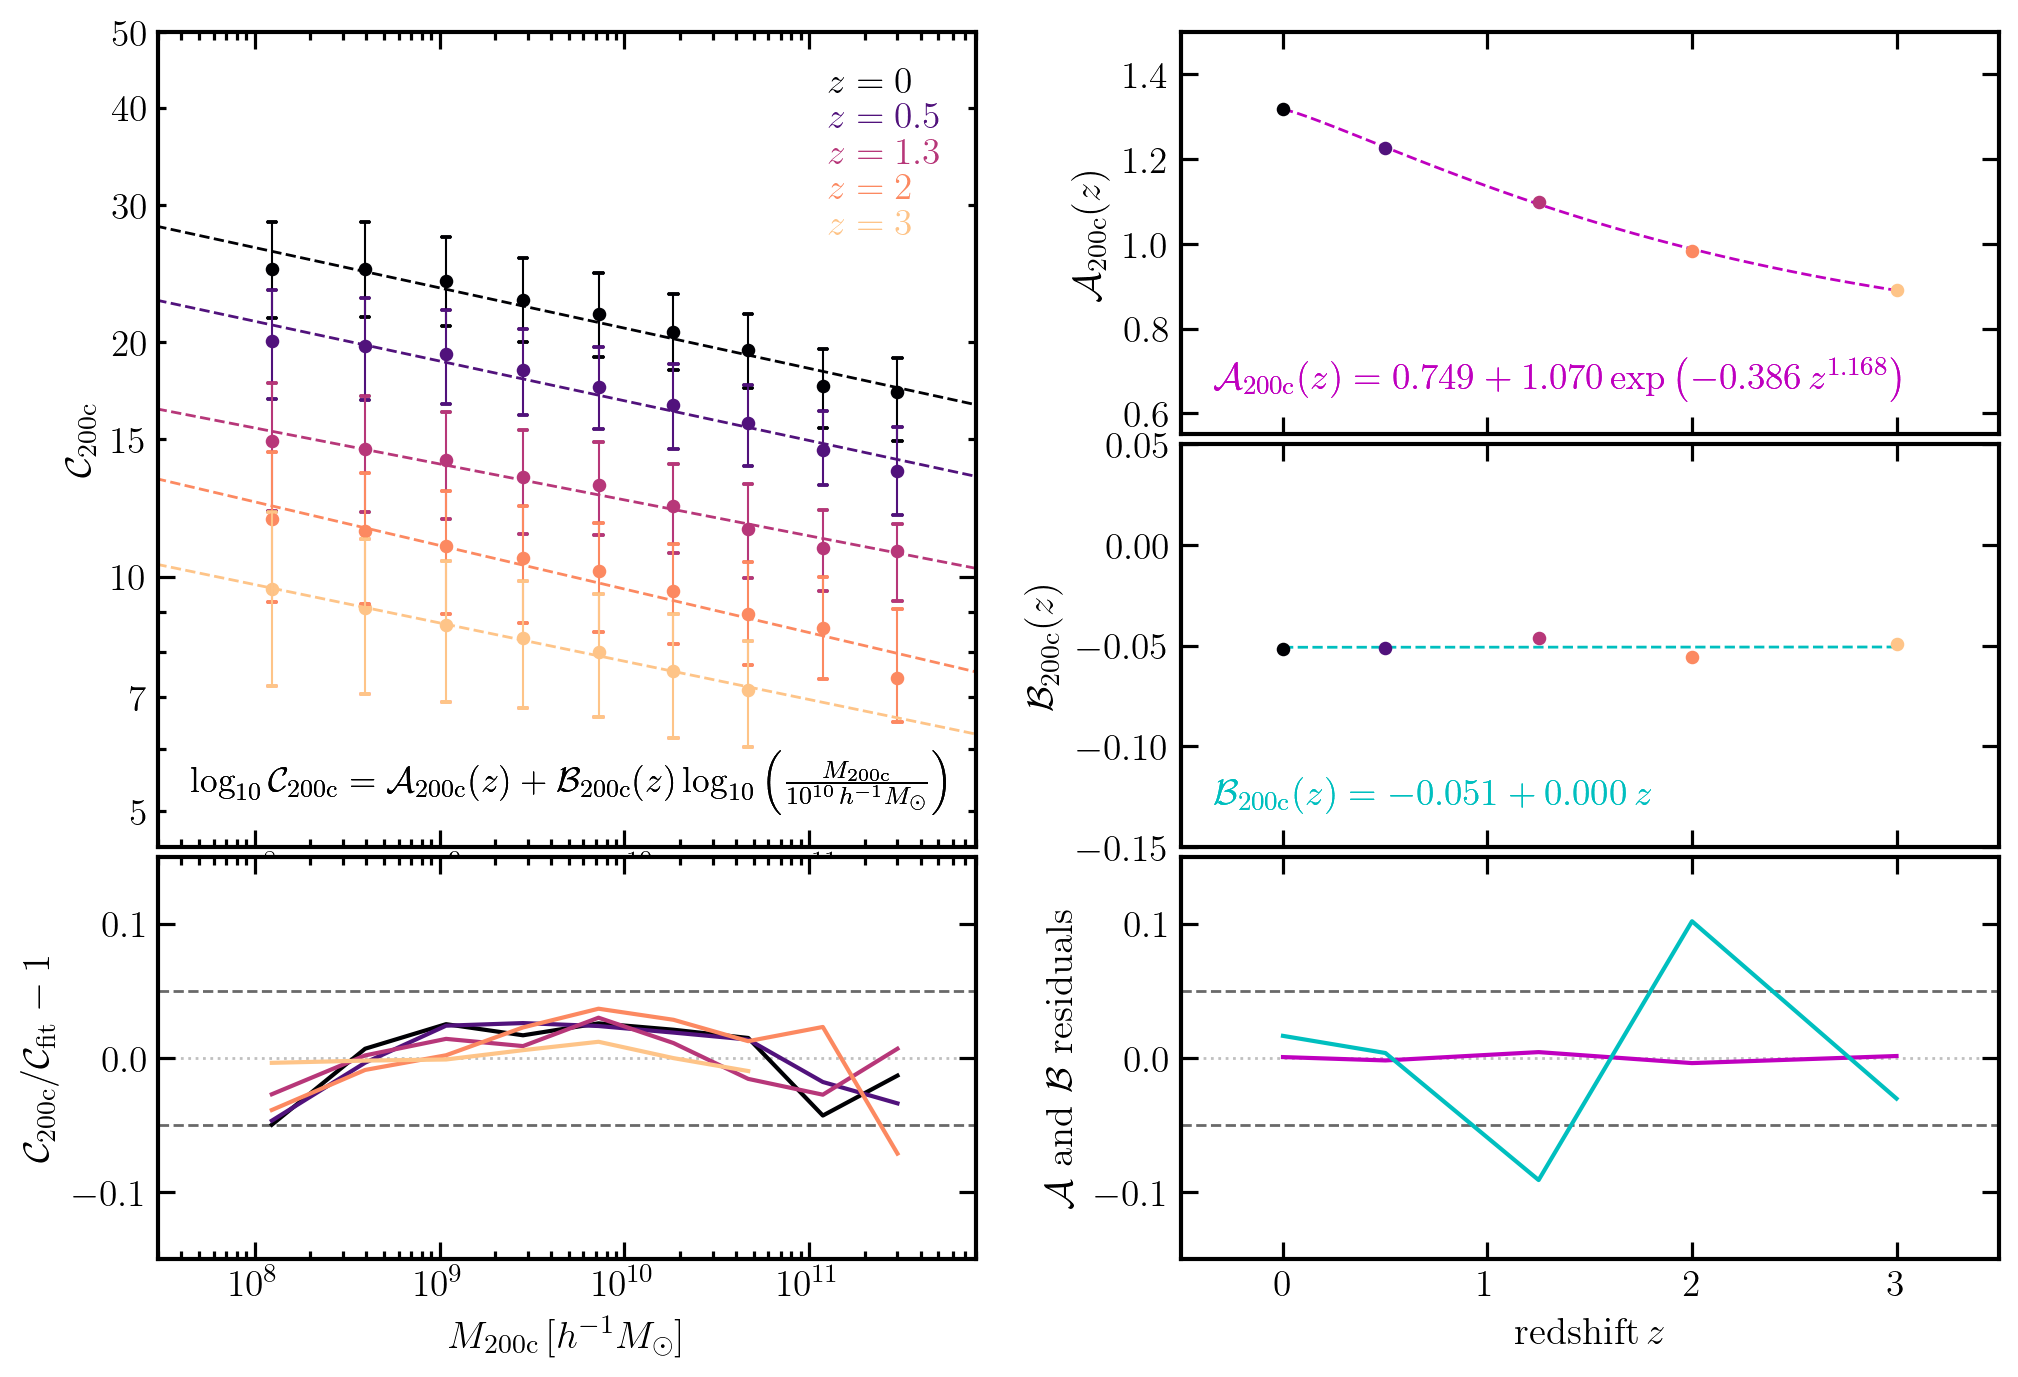

In [75]:
mdefs = ['vir', '200c']

for mdef in mdefs:
    fig,axs=plt.subplots(figsize=(14.25/1.2,9.75/1.2),dpi=100)
    plt.subplots_adjust(wspace=0.25,hspace=0.05)

    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(nrows=6, ncols=2)

    # -----------------------------------------------------------------------------------------

    ax0 = plt.subplot(gs[:4, 0]) # row 1, span all columns
    ax0.xaxis.set_tick_params(direction='in', which='both'); ax0.yaxis.set_tick_params(direction='in', which='both')
    ax0.xaxis.set_ticks_position('both'); ax0.yaxis.set_ticks_position('both')
    ax0.set_xlabel(r'$M_{\rm %s}\, [h^{-1}M_{\odot}]$' % (mdef)); ax0.set_ylabel(r'$\mathcal{C}_{\rm %s}$' % (mdef))
    ax0.set_xscale('log'); ax0.set_yscale('log');
    ax0.set_xlim(3e7, 8e11); ax0.set_ylim(4.5, 50)

    ax0.set_yticks([5,6,7,8,9,15,20,30,40,50],minor=True)
    ax0.set_yticklabels([r'$5$','',r'$7$','','',r'$15$',r'$20$',r'$30$',r'$40$','$50$'], fontsize=13.5,minor=True)
    ax0.set_yticks([10])
    ax0.set_yticklabels([r'$10$'], fontsize=13.5)

    from matplotlib.patches import Rectangle
    empty = Rectangle((0,0), 0, 0, alpha=0.0)
    sim_leg = ax0.legend([empty]*7,
                    [r'$z = 0$',
                    r'$z = 0.5$',
                    r'$z = 1.3$',
                    r'$z = 2$',
                    r'$z = 3$',],
                    #r'$z = 4$',r'$z = 5.1$'],
                   loc="upper right",frameon=False,ncol=1,
                   fontsize=13.5,handlelength=0,handletextpad=0,labelspacing=0.05)
    sim_leg.get_texts()[0].set_color(color0)
    sim_leg.get_texts()[1].set_color(color05)
    sim_leg.get_texts()[2].set_color(color1)
    sim_leg.get_texts()[3].set_color(color2)
    sim_leg.get_texts()[4].set_color(color3)
    #sim_leg.get_texts()[5].set_color(color4)
    #sim_leg.get_texts()[6].set_color(color5)
    ax0.add_artist(sim_leg)

    sim_str = r'$\log_{10}\mathcal{C}_{\rm %s} = \mathcal{A}_{\rm %s}(z) + \mathcal{B}_{\rm %s}(z) \log_{10}\left( \frac{M_{\rm %s}}{10^{10}\, h^{-1}M_{\odot}} \right)$' \
                % (mdef, mdef, mdef, mdef)
    sim_leg = ax0.legend([empty],
                    [sim_str],
                   loc="lower left",frameon=False,
                   fontsize=13.,handlelength=0,handletextpad=0)
    sim_leg.get_texts()[0].set_color('k')
    ax0.add_artist(sim_leg)

    # -----------------------------------------------------------------------------------------

    '''power law residuals
    '''
    ax1 = plt.subplot(gs[4:, 0]) # row 1, span all columns
    ax1.xaxis.set_tick_params(direction='in', which='both'); ax1.yaxis.set_tick_params(direction='in', which='both')
    ax1.xaxis.set_ticks_position('both'); ax1.yaxis.set_ticks_position('both')
    ax1.set_xlabel(r'$M_{\rm %s}\, [h^{-1}M_{\odot}]$' % (mdef)); ax1.set_ylabel(r'$\mathcal{C}_{\rm %s}/\mathcal{C}_{\rm fit} - 1$' % (mdef))
    ax1.set_xscale('log'); ax1.set_yscale('linear');
    ax1.set_xlim(3e7, 8e11); ax1.set_ylim(-0.15, 0.15)

    m_arr = 10.0 ** np.linspace(7, 12)
    ax1.plot(m_arr, np.linspace(0.0,0.0), color='silver', lw=1.0, ls=':', zorder=0)
    ax1.plot(m_arr, np.linspace(0.05,0.05), color='dimgray', lw=1.0, ls='--', zorder=0)
    ax1.plot(m_arr, np.linspace(-0.05,-0.05), color='dimgray', lw=1.0, ls='--', zorder=0)

    '''A(z) fit
    '''
    ax2 = plt.subplot(gs[0:2, 1]) # row 0, col 1
    ax2.xaxis.set_tick_params(direction='in', which='both'); ax2.yaxis.set_tick_params(direction='in', which='both')
    ax2.xaxis.set_ticks_position('both'); ax2.yaxis.set_ticks_position('both')
    ax2.set_ylabel(r'$\mathcal{A}_{\rm %s}(z)$' % (mdef))
    ax2.set_xscale('linear'); ax2.set_yscale('linear');
    ax2.set_xlim(-0.5,3.5); ax2.set_ylim(0.55,1.5)

    '''B(z) fit
    '''
    ax3 = plt.subplot(gs[2:4, 1]) # row 0, col 0
    ax3.xaxis.set_tick_params(direction='in', which='both'); ax3.yaxis.set_tick_params(direction='in', which='both')
    ax3.xaxis.set_ticks_position('both'); ax3.yaxis.set_ticks_position('both')
    ax3.set_ylabel(r'$\mathcal{B}_{\rm %s}(z)$' % (mdef))
    ax3.set_xscale('linear'); ax3.set_yscale('linear');
    ax3.set_xlim(-0.5,3.5); ax3.set_ylim(-0.15,0.05)

    '''redshift evolution residuals
    '''
    ax4 = plt.subplot(gs[4:, 1]) # row 0, col 0
    ax4.xaxis.set_tick_params(direction='in', which='both'); ax4.yaxis.set_tick_params(direction='in', which='both')
    ax4.xaxis.set_ticks_position('both'); ax4.yaxis.set_ticks_position('both')
    ax4.set_xlabel(r'$\mathrm{redshift}\, z$'); ax4.set_ylabel(r'$\rm \mathcal{A}\ and\ \mathcal{B}\ residuals$')
    ax4.set_xscale('linear'); ax4.set_yscale('linear');
    ax4.set_xlim(-0.5,3.5); ax4.set_ylim(-0.15,0.15)

    zarr = np.linspace(-0.5, 3.5)
    ax4.plot(zarr, np.linspace(0.0,0.0), color='silver', lw=1.0, ls=':', zorder=0)
    ax4.plot(zarr, np.linspace(0.05,0.05), color='dimgray', lw=1.0, ls='--', zorder=0)
    ax4.plot(zarr, np.linspace(-0.05,-0.05), color='dimgray', lw=1.0, ls='--', zorder=0)

    # -----------------------------------------------------------------------------------------

    rf = RegressionFits()

    # ax0 and ax1 plots
    m_arr = 10.0 ** np.linspace(7, 12)
    zvals, avals, bvals = [], [], []
    for ind, zref in enumerate(rf.list_avail_redshifts()):
        # load relavent parameters
        proj_res = rf.concatenate_proj_results(mdef=mdef)[zref]  
        xdata, ydata = proj_res['mass']*h0, proj_res['C.1']
        mask = (mmin < xdata) & (xdata < mmax)

        stats = rf.get_statistics(xdata=xdata[mask], ydata=ydata[mask],
                                  nbins=10, 
                                  xbound=(7e7, 3e11),
                                  clean_up=True)
        if zref == 'z3.000':
            mask = stats['x.bins'] < 5e10
            for skey, sval in stats.items():
                stats[skey] = sval[mask] 
                
        popt = rf.power_law_fit(xdata=stats['x.bins'], ydata=stats['y.median'])
        zvals.append(np.float64(zref[1:]))
        avals.append(popt[0])
        bvals.append(popt[1])

        # ax0 plots main fit results
        color = rf.color_ref_by_redshift()[zref]
        rf.plot_stats_scatter(stats=stats, axs=ax0, color=color)
        yfit = rf.power_law(m_arr, *popt)
        ax0.plot(m_arr, yfit, lw=1.0, ls='--', color=color)

        # ax1 plots main fit residuals
        yfit = rf.power_law(stats['x.bins'], *popt)
        resids = stats['y.median']/yfit - 1.0
        ax1.plot(stats['x.bins'], resids, color=color, lw=1.5)
    zvals, avals, bvals = np.array(zvals), np.array(avals), np.array(bvals)

    # -----------------------------------------------------------------------------------------

    # ax2 and ax3 scatter
    for ind, zref in enumerate(rf.list_avail_redshifts()):    
        color = rf.color_ref_by_redshift()[zref]
        ax2.scatter(zvals[ind], avals[ind], color=color, s=15)
        ax3.scatter(zvals[ind], bvals[ind], color=color, s=15)
    
    a_popt = rf.power_law_fit(xdata=zvals, ydata=avals, 
                              func=rf.a_fit, 
                              guess=(0.655, 0.633, 0.5, -0.440, 1.146))
   
    b_popt = rf.power_law_fit(xdata=zvals, ydata=bvals, 
                              func=rf.b_fit)
    
    z_arr = np.linspace(0.0, 3.0)
    ax2.plot(z_arr, rf.a_fit(z_arr, *a_popt), color='m', ls='--', lw=1.0, zorder=0)
    ax3.plot(z_arr, rf.b_fit(z_arr, *b_popt), color='c', ls='--', lw=1.0, zorder=0)
    
    a_str = r'$\mathcal{A}_{\rm %s}(z) = %.3f + %.3f \exp\left( %.3f\,z^{%.3f} \right)$' % (mdef, a_popt[0], (a_popt[1]+a_popt[2]), a_popt[3], a_popt[4])
    leg2 = ax2.legend([empty], [a_str],
                       loc="lower left", frameon=False, fontsize=13.5,handlelength=0,handletextpad=0)
    leg3 = ax3.legend([empty], [r'$\mathcal{B}_{\rm %s}(z) = %.3f + %.3f\, z$' % (mdef, b_popt[0], b_popt[1])],
                       loc="lower left", frameon=False, fontsize=13.5,handlelength=0,handletextpad=0)
    leg2.get_texts()[0].set_color('m'); ax2.add_artist(leg2)
    leg3.get_texts()[0].set_color('c'); ax3.add_artist(leg3)

    # residuals for A(z)
    afit = rf.a_fit(zvals, *a_popt)
    residuals_a = avals/afit - 1.0
    ax4.plot(zvals, residuals_a, color='m', lw=1.5, ls='-')
    
    # residuals for B(z)
    bfit = rf.b_fit(zvals, *b_popt)
    residuals_b = bvals/bfit - 1.0
    ax4.plot(zvals, residuals_b, color='c', lw=1.5, ls='-')

    # -----------------------------------------------------------------------------------------

    plt.show()     

---

# Diemer and Joyce (2019) model

In [28]:
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import least_squares

class DJ19(BaseAnalysis):
    
    def __init__(self, mbounds: float = None, halo_fields=None, model: str = 'nfw', *args, **kwargs) -> None:
        super().__init__(mbounds, halo_fields, *args, **kwargs)
        name_list = ['einasto', 'nfw', 'lazar']
        if model not in name_list:
            raise KeyError(f"!!! `{model}` is not an available profile!!!")
        else:
            self.model = model

    def compute_peak_height(self, z: float, mass: float) -> float:
        """Computes the linear peak height from a given halo mass [Msol/h]"""
        from colossus.lss import peaks
        return peaks.peakHeight(mass, z=z);
    
    def mu_nfw(self, x: float) -> float:
        return np.log(1.0+x) - x/(1.0+x)

    def mu_einasto(self, x: float) -> float:
        alpha = 0.17
        integrand = lambda xx: xx * xx * np.exp(-2. / alpha * (xx**alpha))
        if isinstance(x, np.ndarray):
            result = np.zeros(x.shape[0])
            for i in range(x.shape[0]):
                result[i] += np.exp(2.0/alpha) * quad(integrand, 0.0, x[i])[0]
        else:
            result =  np.exp(2.0/alpha) * quad(integrand, 0.0, x)[0]
        return result

    def mu_lazar(self, x: float) -> float:
        beta = 0.3
        integrand = lambda xx: xx * np.exp(-1. / beta * xx**beta)
        if isinstance(x, np.ndarray):
            result = np.zeros(x.shape[0])
            for i in range(x.shape[0]):
                result[i] += np.exp(1.0/beta) * quad(integrand, 0., x[i])[0]
        else:
            result = np.exp(1.0/beta) * quad(integrand, 0.0, x)[0]
        return result
    
    def mu_profile(self, x: float) -> float:     
        if self.model == 'einasto':
            result = self.mu_einasto(x)
        elif self.model == 'lazar':
            result = self.mu_lazar(x)
        elif self.model == 'nfw':
            result = self.mu_nfw(x)
        return result
    
    def function(self, M: float, z: float, 
                       kappa: float, a0: float, a1: float, b0: float, b1: float, c_alpha: float, 
                       *args, **kwargs):

        from colossus.lss import peaks
        from colossus.halo import concentration
        # compute peak height, n_eff, and alpha_eff
        nu = peaks.peakHeight(M, z)
        n_eff = peaks.powerSpectrumSlope(nu, z, slope_type='sigma', scale=kappa)        
        alpha_eff = concentration._diemer19_alpha_eff(z)

        # Compute input parameters and the right-hand side of the c-M equation. We use interpolation
        # tables to find the concentration at which the equation gives that RHS.
        A_n = a0 * (1.0 + a1*(n_eff+3.0))
        B_n = b0 * (1.0 + b1*(n_eff+3.0))
        C_alpha = 1.0 - c_alpha*(1.0-alpha_eff)
        rhs = np.log10(A_n/nu * (1.0+nu**2/B_n))

        def computeGcTable():
            """
            Following line 1313 and onward in concentration.py. This necesary to conjure the inverse functions.
            """
            results = dict()
            
            # generate grid parameter space for density structure parameter
            n_G, n_n, n_c = 80, 40, 80
            n = np.linspace(-4.0, 0.0, n_n)
            c = np.linspace(-1.0, 3.0, n_c)
            lin_c = 10.0**c
            mu = self.mu_profile(lin_c)

            # generate matric table // LHS for Eq. 31 of DJ19
            lhs = np.log10(lin_c[:, None]/mu[:, None]**((5.0+n)/6.0))

            # At very low concentration and shallow slopes, the LHS begins to rise again. This will cause
            # issues with the inversion. We set those parts of the curve to the minimum concentration of 
            # a given n bin.
            mask_ascending = np.ones_like(lhs, bool)
            mask_ascending[:-1, :] = (np.diff(lhs, axis=0) > 0.0)
            
            # Create a table of c as a function of G and n. First, use the absolute min and max of G as the table range
            G_min = np.min(lhs); G_max = np.max(lhs)
            G = np.linspace(G_min, G_max, n_G)

            gc_table = np.ones((n_G, n_n), float) * (-10.0)
            mins = np.zeros_like(n); maxs = np.zeros_like(n)
            for i in range(n_n):
                
                # we interpolate only the ascending values to get c(G)
                mask_ = mask_ascending[:, i]
                lhs_ = lhs[mask_, i]
                mins[i] = np.min(lhs_); maxs[i] = np.max(lhs_)
                interp = InterpolatedUnivariateSpline(lhs_, c[mask_])

                # not all G exist for all n, mask condition those out
                mask = (G >= mins[i]) & (G <= maxs[i])
                res = interp(G[mask])
                gc_table[mask, i] = res

                mask_low = (G < mins[i]); mask_high = (G > maxs[i])
                gc_table[mask_low, i] = np.min(res)
                gc_table[mask_high, i] = np.max(res)
            
            # return resulting grid to dictionary
            results['Gc'] = (G, n, gc_table)
            results['Gmin'] = np.array([n, mins])
            results['Gmax'] = np.array([n, maxs])
            return results
        
        def interpolators():
            """
            """
            results = dict()
            gcTable = computeGcTable()

            # Grid == False?
            results['interp_Gc'] = RectBivariateSpline(gcTable['Gc'][0], 
                                                       gcTable['Gc'][1],
                                                       gcTable['Gc'][2], 
                                                       kx=3, 
                                                       ky=3)

            Gvals = ['Gmax', 'Gmin']
            for Gval in Gvals:
                # interpolatio grid
                results[f'interp_{Gval}'] = InterpolatedUnivariateSpline(gcTable[Gval][0], 
                                                                         gcTable[Gval][1])
                
                # check if Gval grid is in ascending order
                cond1 = gcTable[Gval][1][-1] < gcTable[Gval][1][0]
                if cond1: 
                    gcTable[Gval] = gcTable[Gval][:, ::-1]
                    
                # inverse interpolation grid method
                cond2 = np.min(np.diff(gcTable[Gval][1])) == 0.0
                if cond2:
                    mask = np.ones(len(gcTable[Gval][1]), np.bool)
                    mask[1:] = (np.diff(gcTable[Gval][1]) > 0.0)
                    n_removed = len(mask) - np.count_nonzero(mask)
                    warnings.warn(f"While inverting interpolator {Gval}, removed {n_removed} flat values from the data.")
                    results[f"interp_{Gval}:inverse"] = InterpolatedUnivariateSpline(gcTable[Gval][1][mask], 
                                                                                     gcTable[Gval][0][mask])
                else:
                    results[f"interp_{Gval}:inverse"] = InterpolatedUnivariateSpline(gcTable[Gval][1],
                                                                                     gcTable[Gval][0])
            return results

        
        # Get interpolation table
        intp = interpolators()
        c = 10.0 ** intp['interp_Gc'](rhs, n_eff, grid = False) * C_alpha
        return c
    
    def least_squares_fit(self, zdata:float, xdata: float, ydata: float) -> float:
        """
        """
        
        x0 = np.array([1.64, 2.67, 1.23, 3.92, 1.30, -0.19], dtype = float)
        lbounds = (1e-5, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf)
        ubounds = (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf)
        
        def model_function(x: float, z: float, params) -> float:
            return self.function(x, z, params[0], params[1], params[2], params[3], params[4], params[5])
        
        def residuals(params, zval: float, yval: float, xval: float):
            """Simply the difference between the data and model"""
            results = list()
            for i in range(len(zval)):
                res = yval[i] - model_function(xval[i], zval[i], params) 
                results.append(res)
            return np.concatenate(results)
        
        lsq_res = least_squares(residuals, 
                                x0=x0, 
                                bounds=(lbounds, ubounds), 
                                args=(zdata, ydata, xdata))
        return lsq_res

---
### (Einasto) Concentration - Mass Relation [DJ19] // $M_{\rm vir}$ and $c_{\rm vir}$.

In [74]:
dja =  DJ19(model='einasto')

# overdensity models to fit over
mdefs = ['vir', '200c']
for mdef in mdefs:
    
    print("-" * 75)
    print(f"Overdensity definition: {mdef}")
    print("-" * 75)
    # call all concentration relation data for each characteristic redshift 
    zred_list = list()
    conc_list = list()
    mass_list = list()
    for ind, zref in enumerate(rf.list_avail_redshifts()):
        # load relavent parameters
        xdata, ydata = dja.data[zref][f'mass.{mdef}']*h0, dja.data[zref][f'ein:c.{mdef}']
        mask = (mmin < xdata) & (xdata < mmax)
        # median conc-mass relation
        stats = dja.get_statistics(xdata=xdata[mask], ydata=ydata[mask],
                                  nbins=10, 
                                  xbound=(7e7, 3e11),
                                  clean_up=True)
        if zref == 'z3.000':
            mask = stats['x.bins'] < 5e10
            for skey, sval in stats.items():
                stats[skey] = sval[mask] 
        conc_list.append(stats['y.median'])
        mass_list.append(stats['x.bins'])
        zred_list.append(np.float64(zref[1:]))
    zred_list = np.array(zred_list)
    conc_list = np.array(conc_list)
    mass_list = np.array(mass_list)
    
    lsq_res = dja.least_squares_fit(zdata=zred_list, 
                                    xdata=mass_list, 
                                    ydata=conc_list)
    
    print(dja.function(1e10, 0.0, *lsq_res.x))
    
    print(":" * 25, 'Best-fit Parameters', ":" * 25)
    print(lsq_res.x)
    print(f'kappa: {lsq_res.x[0]}')
    print(f'a0: {lsq_res.x[1]}')
    print(f'a1: {lsq_res.x[2]}')
    print(f'b0: {lsq_res.x[3]}')
    print(f'b1: {lsq_res.x[4]}')
    print(f'c_alpha: {lsq_res.x[5]}')

---------------------------------------------------------------------------
Overdensity definition: vir
---------------------------------------------------------------------------


/var/folders/9r/jd9klpcj2dv72j41rwrdmwjh0000gn/T/ipykernel_60085/4006819171.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  conc_list = np.array(conc_list)
/var/folders/9r/jd9klpcj2dv72j41rwrdmwjh0000gn/T/ipykernel_60085/4006819171.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mass_list = np.array(mass_list)


17.850781144444202
::::::::::::::::::::::::: Best-fit Parameters :::::::::::::::::::::::::
[ 0.07379263  0.17432797 40.5214432  11.1111569   0.42151765 -0.21168289]
kappa: 0.07379262953277298
a0: 0.17432797481038612
a1: 40.52144319579862
b0: 11.111156903798888
b1: 0.42151765296878274
c_alpha: -0.21168288732710078
---------------------------------------------------------------------------
Overdensity definition: 200c
---------------------------------------------------------------------------
13.700825918299476
::::::::::::::::::::::::: Best-fit Parameters :::::::::::::::::::::::::
[ 0.06393782  0.3006458  22.21339147 11.80612636  0.45172196  0.25090279]
kappa: 0.06393782267871465
a0: 0.30064580274195307
a1: 22.213391465852744
b0: 11.806126359038233
b1: 0.45172195565635115
c_alpha: 0.25090278765867124


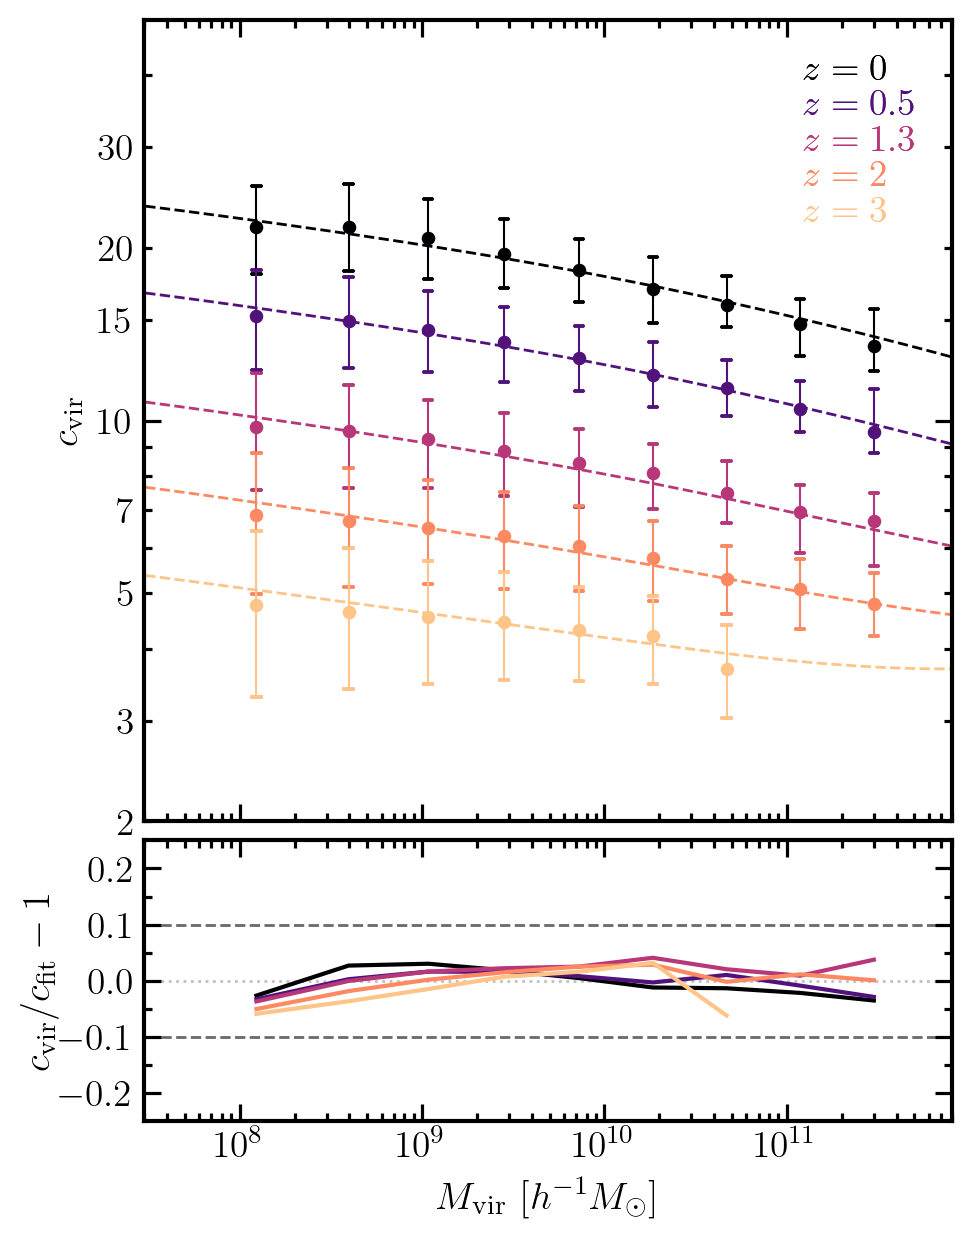

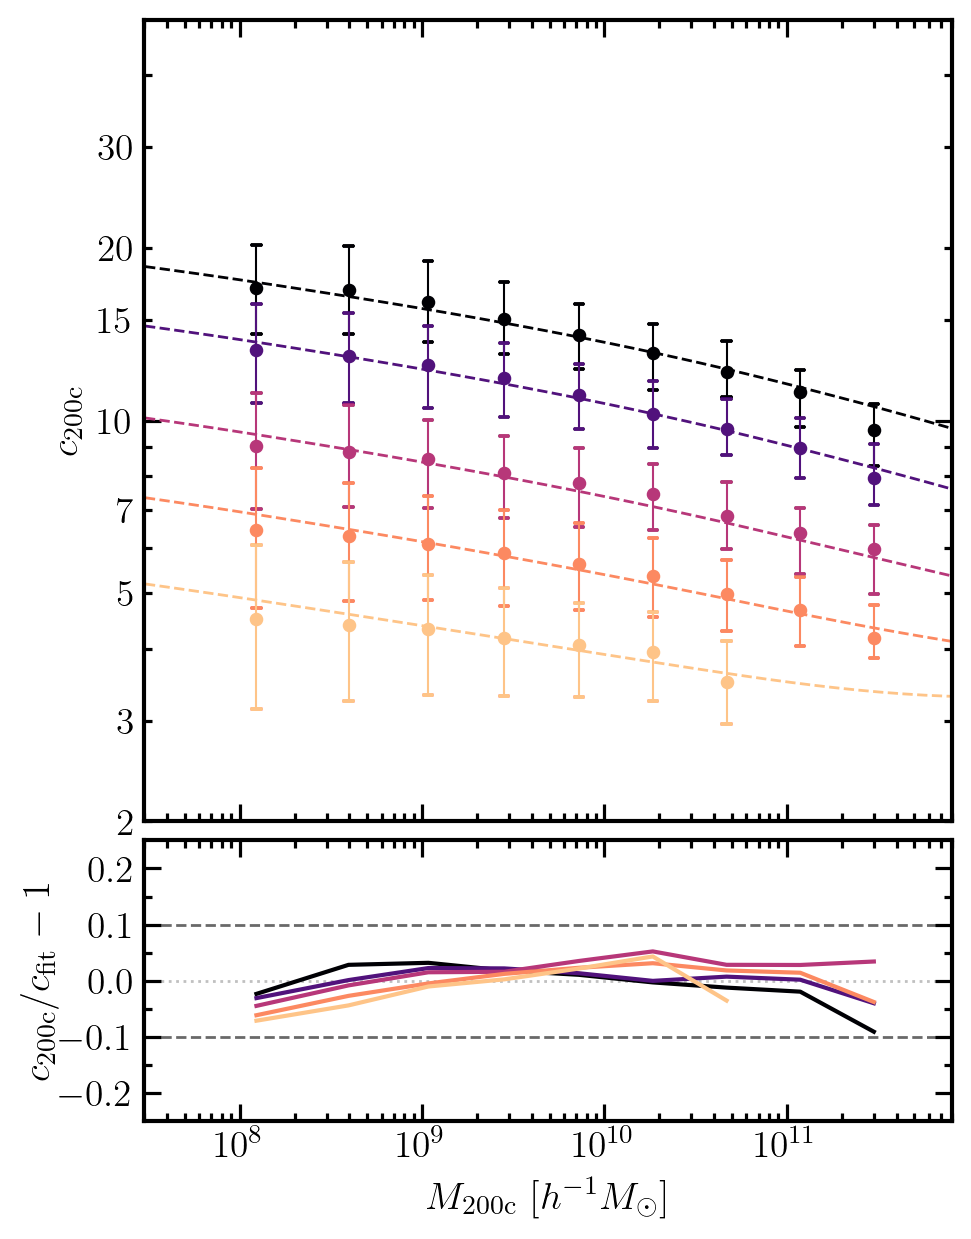

In [76]:
dja =  DJ19(model='einasto')

# overdensity models to fit over
mdefs = ['vir', '200c']
for mdef in mdefs:
    fig, axs = plt.subplots(figsize=(6.25/1.2, 8.75/1.2),
                           nrows=2, ncols=1, 
                           gridspec_kw={'height_ratios': [1, 0.35,]},
                           dpi=100)
    plt.subplots_adjust(wspace=0.1, hspace=0.035)
    
    # -----------------------------------------------------------------------------------------

    axs[0].xaxis.set_tick_params(direction='in', which='both'); axs[0].yaxis.set_tick_params(direction='in', which='both')
    axs[0].xaxis.set_ticks_position('both'); axs[0].yaxis.set_ticks_position('both')
    axs[0].set_xlabel(r'$M_{\rm %s}\ [h^{-1}M_{\odot}]$' % (mdef)); 
    axs[0].set_ylabel(r'$c_{\rm %s}$' % (mdef))
    axs[0].set_xscale('log'); axs[0].set_yscale('log');
    axs[0].set_xlim(3e7, 8e11); axs[0].set_ylim(4.5,50)
    axs[0].set_xticklabels([])

    axs[0].set_yticks([2,3,4,5,6,7,8,9,15,20,30,40],minor=True)
    axs[0].set_yticklabels([r'$2$',r'$3$','',r'$5$','',r'$7$','','',r'$15$',r'$20$',r'$30$',''], fontsize=13.5,minor=True)
    axs[0].set_yticks([10])
    axs[0].set_yticklabels([r'$10$'], fontsize=13.5)

    axs[1].xaxis.set_tick_params(direction='in', which='both'); axs[1].yaxis.set_tick_params(direction='in', which='both')
    axs[1].xaxis.set_ticks_position('both'); axs[1].yaxis.set_ticks_position('both')
    axs[1].set_xlabel(r'$M_{\rm %s}\ [h^{-1}M_{\odot}]$' % (mdef)); 
    axs[1].set_ylabel(r'$c_{\rm %s}/c_{\rm fit} - 1$' % (mdef), labelpad=-0.0)
    axs[1].set_xscale('log'); axs[1].set_yscale('linear');
    axs[1].set_xlim(3e7,8e11); axs[1].set_ylim(-0.25,0.25)

    major_ticks = np.array([-0.2, -0.1, 0, 0.1, 0.2]) #np.arange(-0.4, 0.4, 5)
    minor_ticks = np.array([-0.15, -0.05, 0.05, 0.15]) #np.arange(0, 101, 5)
    axs[1].set_yticks(major_ticks)
    axs[1].set_yticks(minor_ticks, minor=True)
    
    # -----------------------------------------------------------------------------------------

    cmap = matplotlib.cm.get_cmap('magma')
    color0=cmap(0.0)
    color05=cmap(0.25)
    color1=cmap(0.5)
    color2=cmap(0.75)
    color3=cmap(0.875)
    
    if mdef == 'vir':
        from matplotlib.patches import Rectangle
        empty = Rectangle((0,0), 0, 0, alpha=0.0)
        sim_leg = axs[0].legend([empty]*7,
                        [r'$z = 0$',
                        r'$z = 0.5$',
                        r'$z = 1.3$',
                        r'$z = 2$',
                        r'$z = 3$'],
                       loc="upper right",frameon=False,ncol=1,
                       fontsize=13.5,handlelength=0,handletextpad=0,labelspacing=0.05)
        sim_leg.get_texts()[0].set_color(color0)
        sim_leg.get_texts()[1].set_color(color05)
        sim_leg.get_texts()[2].set_color(color1)
        sim_leg.get_texts()[3].set_color(color2)
        sim_leg.get_texts()[4].set_color(color3)
        axs[0].add_artist(sim_leg)
        
    # -----------------------------------------------------------------------------------------
    
    m_arr = 10**np.linspace(6.0, 12.0)
    if mdef == 'vir':
        params =  [0.07379263, 0.17432797, 40.5214432, 11.1111569, 0.42151765, -0.21168289]
    elif mdef == '200c':
        params = [0.06393782, 0.3006458, 22.21339147, 11.80612636, 0.45172196, 0.25090279]
    
    def func(x, z, params):
        return dja.function(x, z, params[0], params[1], params[2], params[3], params[4], params[5])
    
    # call all concentration relation data for each characteristic redshift 
    for ind, zref in enumerate(dja.list_avail_redshifts()):
        # load relavent parameters
        xdata, ydata = dja.data[zref][f'mass.{mdef}']*h0, dja.data[zref][f'ein:c.{mdef}']
        mask = (mmin < xdata) & (xdata < mmax)
        # median conc-mass relation
        stats = dja.get_statistics(xdata=xdata[mask], ydata=ydata[mask],
                                  nbins=10, 
                                  xbound=(7e7, 3e11),
                                  clean_up=True)
        
        if zref == 'z3.000':
            mask = stats['x.bins'] < 5e10
            for skey, sval in stats.items():
                stats[skey] = sval[mask] 
        
        # axs[0] plots main fit results
        color = dja.color_ref_by_redshift()[zref]
        dja.plot_stats_scatter(stats=stats, axs=axs[0], color=color)
        
        # plot resulting fits
        yfit = func(x=m_arr, z=np.float64(zref[1:]), params=params)
        axs[0].plot(m_arr, yfit, color=color, ls='--', lw=1.0)
                    
        # plot residuals
        yfit_data = func(x=stats['x.bins'], z=np.float64(zref[1:]), params=params)
        residual = stats['y.median']/yfit_data - 1.0
        axs[1].plot(stats['x.bins'], residual, ls='-', lw=1.5, color=color)
        
        if mdef == 'vir' and zref == 'z0.501':
            marr = 10**np.linspace(5.0, 10.0, 100)
            y02 = func(marr, 0.2, params=params)
            np.savetxt(fname="effconc_DJ19_z02.txt", X=np.column_stack((marr, y02)))
        
    axs[1].plot(m_arr, np.linspace(0.0, 0.0), color='silver', lw=1.0, ls=':', zorder=0)
    axs[1].plot(m_arr, np.linspace(0.1, 0.1), color='dimgray', lw=1.0, ls='--', zorder=0)
    axs[1].plot(m_arr, np.linspace(-0.1, -0.1), color='dimgray', lw=1.0, ls='--', zorder=0)

---

### Project Concentation as a funciton as a Peak height

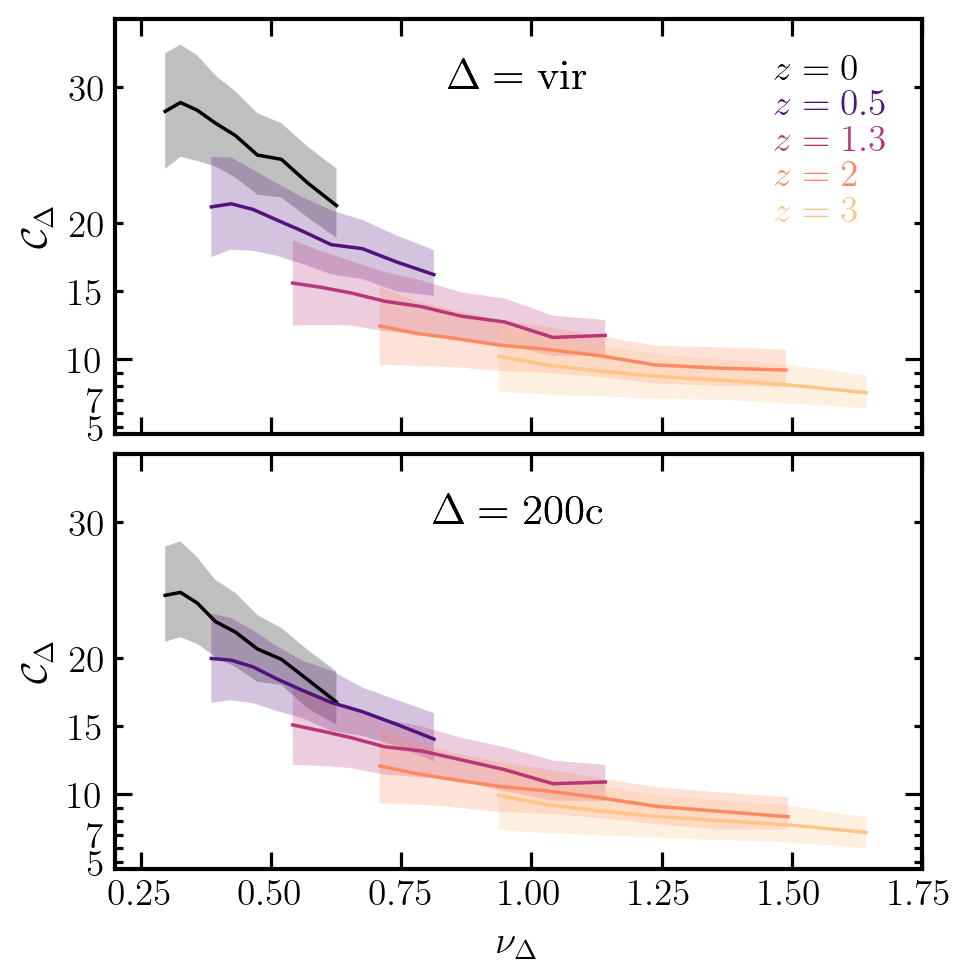

In [72]:
fig,axs=plt.subplots(figsize=(6.25/1.2, 6.75/1.2), nrows=2, ncols=1, dpi=100)
plt.subplots_adjust(wspace=0.25, hspace=0.05)

cmap = matplotlib.cm.get_cmap('magma')
color0=cmap(0.0)
color05=cmap(0.25)
color1=cmap(0.5)
color2=cmap(0.75)
color3=cmap(0.875)

from matplotlib.patches import Rectangle
empty = Rectangle((0,0), 0, 0, alpha=0.0)
sim_leg = axs[0].legend([empty]*7,
                [r'$z = 0$',
                r'$z = 0.5$',
                r'$z = 1.3$',
                r'$z = 2$',
                r'$z = 3$'],
               loc="upper right",frameon=False,ncol=1,
               fontsize=13.5,handlelength=0,handletextpad=0,labelspacing=0.05)
sim_leg.get_texts()[0].set_color(color0)
sim_leg.get_texts()[1].set_color(color05)
sim_leg.get_texts()[2].set_color(color1)
sim_leg.get_texts()[3].set_color(color2)
sim_leg.get_texts()[4].set_color(color3)
axs[0].add_artist(sim_leg)

# -----------------------------------------------------------------------------------------

axs[0].xaxis.set_tick_params(direction='in', which='both'); axs[0].yaxis.set_tick_params(direction='in', which='both')
axs[0].xaxis.set_ticks_position('both'); axs[0].yaxis.set_ticks_position('both')
axs[0].set_ylabel(r'$\mathcal{C}_{\Delta}$')
axs[0].set_xscale('linear'); axs[0].set_yscale('linear');
axs[0].set_xlim(0.2,1.75); axs[0].set_ylim(4.5,35)
#axs.set_ylim(1,200)

axs[0].set_yticks([5,6,7,8,9,15,20,30],minor=True)
axs[0].set_yticklabels([r'$5$','',r'$7$','','',r'$15$',r'$20$',r'$30$'], fontsize=13.5,minor=True)
axs[0].set_yticks([10])
axs[0].set_yticklabels([r'$10$'], fontsize=13.5)

axs[0].axes.xaxis.set_ticklabels([])

sim_leg = axs[0].legend([empty]*7,
                [r'$\rm \Delta = vir$'],
               loc="upper center",frameon=False,ncol=1,
               fontsize=15.5,handlelength=0,handletextpad=0,labelspacing=0.05)
sim_leg.get_texts()[0].set_color('k')
axs[0].add_artist(sim_leg)

# -----------------------------------------------------------------------------------------

axs[1].xaxis.set_tick_params(direction='in', which='both'); axs[1].yaxis.set_tick_params(direction='in', which='both')
axs[1].xaxis.set_ticks_position('both'); axs[1].yaxis.set_ticks_position('both')
axs[1].set_xlabel(r'$\nu_{\Delta}$'); axs[1].set_ylabel(r'$\mathcal{C}_{\Delta}$')
axs[1].set_xscale('linear'); axs[1].set_yscale('linear');
axs[1].set_xlim(0.2,1.75); axs[1].set_ylim(4.5,35)
#axs.set_ylim(1,200)

axs[1].set_yticks([5,6,7,8,9,15,20,30],minor=True)
axs[1].set_yticklabels([r'$5$','',r'$7$','','',r'$15$',r'$20$',r'$30$'], fontsize=13.5,minor=True)
axs[1].set_yticks([10])
axs[1].set_yticklabels([r'$10$'], fontsize=13.5)

sim_leg = axs[1].legend([empty]*7,
                [r'$\rm \Delta = 200c$'],
               loc="upper center",frameon=False,ncol=1,
               fontsize=15.5,handlelength=0,handletextpad=0,labelspacing=0.05)
sim_leg.get_texts()[0].set_color('k')
axs[1].add_artist(sim_leg)

# -----------------------------------------------------------------------------------------


def plot_line(data, axs, color):
    axs.plot(data['x.bins'], data['y.median'], color=color, lw=1.25)
    axs.fill_between(data['x.bins'], data['y.1sigma.lower'], data['y.1sigma.upper'], facecolor=color, edgecolor="None", alpha=0.25)
    return 0

mdefs = ['vir', '200c']
for mdef in mdefs:
    if mdef == 'vir':
        ax = axs[0]
    elif mdef == '200c':
        ax = axs[1]
    for ind, zref in enumerate(dja.list_avail_redshifts()):
        # load relavent parameters
        proj_res = dja.concatenate_proj_results(mdef=mdef)[zref]  
        xdata, ydata = proj_res['mass']*h0, proj_res['C.1']
        mask = (mmin < xdata) & (xdata < mmax)
        # median conc-nu relation
        xdata_ = dja.compute_peak_height(z=np.float64(zref[1:]), mass=xdata[mask])
        stats = dja.get_statistics(xdata=xdata_, ydata=ydata[mask],
                                  nbins=10, 
                                  clean_up=True)
        if zref == 'z3.000':
            mask = stats['x.bins'] < dja.compute_peak_height(z=3.000, mass=5e10)
            for skey, sval in stats.items():
                stats[skey] = sval[mask] 
        
        color = dja.color_ref_by_redshift()[zref]
        plot_line(data=stats, axs=ax, color=color)

plt.show()

---
### Projected Concentration-Mass relation [DJ19 fit] //  $M_{\Delta}$ and $\mathcal{C}_{\Delta}$

In [43]:
dja =  DJ19(model='lazar')

# overdensity models to fit over
mdefs = ['vir', '200c']
for mdef in mdefs:
    
    print("-" * 75)
    print(f"Overdensity definition: {mdef}")
    print("-" * 75)
    # call all concentration relation data for each characteristic redshift 
    zred_list = list()
    conc_list = list()
    mass_list = list()
    for ind, zref in enumerate(rf.list_avail_redshifts()):
        # load relavent parameters
        proj_res = dja.concatenate_proj_results(mdef=mdef)[zref]  
        xdata, ydata = proj_res['mass']*h0, proj_res['C.1']
        mask = (mmin < xdata) & (xdata < mmax)
        # median conc-mass relation
        stats = dja.get_statistics(xdata=xdata[mask], ydata=ydata[mask],
                                  nbins=10, 
                                  xbound=(7e7, 3e11),
                                  clean_up=True)
        if zref == 'z3.000':
            mask = stats['x.bins'] < 5e10
            for skey, sval in stats.items():
                stats[skey] = sval[mask] 
        conc_list.append(stats['y.median'])
        mass_list.append(stats['x.bins'])
        zred_list.append(np.float64(zref[1:]))
    zred_list = np.array(zred_list)
    conc_list = np.array(conc_list)
    mass_list = np.array(mass_list)
    
    lsq_res = dja.least_squares_fit(zdata=zred_list, 
                                    xdata=mass_list, 
                                    ydata=conc_list)
    
    print(":" * 25, 'Best-fit Parameters', ":" * 25)
    print(lsq_res.x)
    print(f'kappa: {lsq_res.x[0]}')
    print(f'a0: {lsq_res.x[1]}')
    print(f'a1: {lsq_res.x[2]}')
    print(f'b0: {lsq_res.x[3]}')
    print(f'b1: {lsq_res.x[4]}')
    print(f'c_alpha: {lsq_res.x[5]}')

---------------------------------------------------------------------------
Overdensity definition: vir
---------------------------------------------------------------------------


/var/folders/9r/jd9klpcj2dv72j41rwrdmwjh0000gn/T/ipykernel_60085/2143256988.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  conc_list = np.array(conc_list)
/var/folders/9r/jd9klpcj2dv72j41rwrdmwjh0000gn/T/ipykernel_60085/2143256988.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mass_list = np.array(mass_list)
/var/folders/9r/jd9klpcj2dv72j41rwrdmwjh0000gn/T/ipykernel_60085/2871355761.py:71: RuntimeWarning: invalid value encountered in log10
  rhs = np.log10(A_n/nu * (1.0+nu**2/B_n))


::::::::::::::::::::::::: Best-fit Parameters :::::::::::::::::::::::::
[5.61498433e-01 5.82703348e-01 1.09266367e+01 8.21546911e-02
 1.38014433e+02 6.97727752e-03]
kappa: 0.5614984325690185
a0: 0.5827033477611708
a1: 10.926636722654907
b0: 0.08215469108819999
b1: 138.0144330713218
c_alpha: 0.006977277521649753
---------------------------------------------------------------------------
Overdensity definition: 200c
---------------------------------------------------------------------------
::::::::::::::::::::::::: Best-fit Parameters :::::::::::::::::::::::::
[6.77559080e-02 8.22941835e-02 1.29431121e+02 1.41034338e-02
 1.28496872e+03 3.17961765e-01]
kappa: 0.06775590798772965
a0: 0.08229418351008655
a1: 129.43112116761716
b0: 0.014103433772491408
b1: 1284.9687170605775
c_alpha: 0.3179617647799778


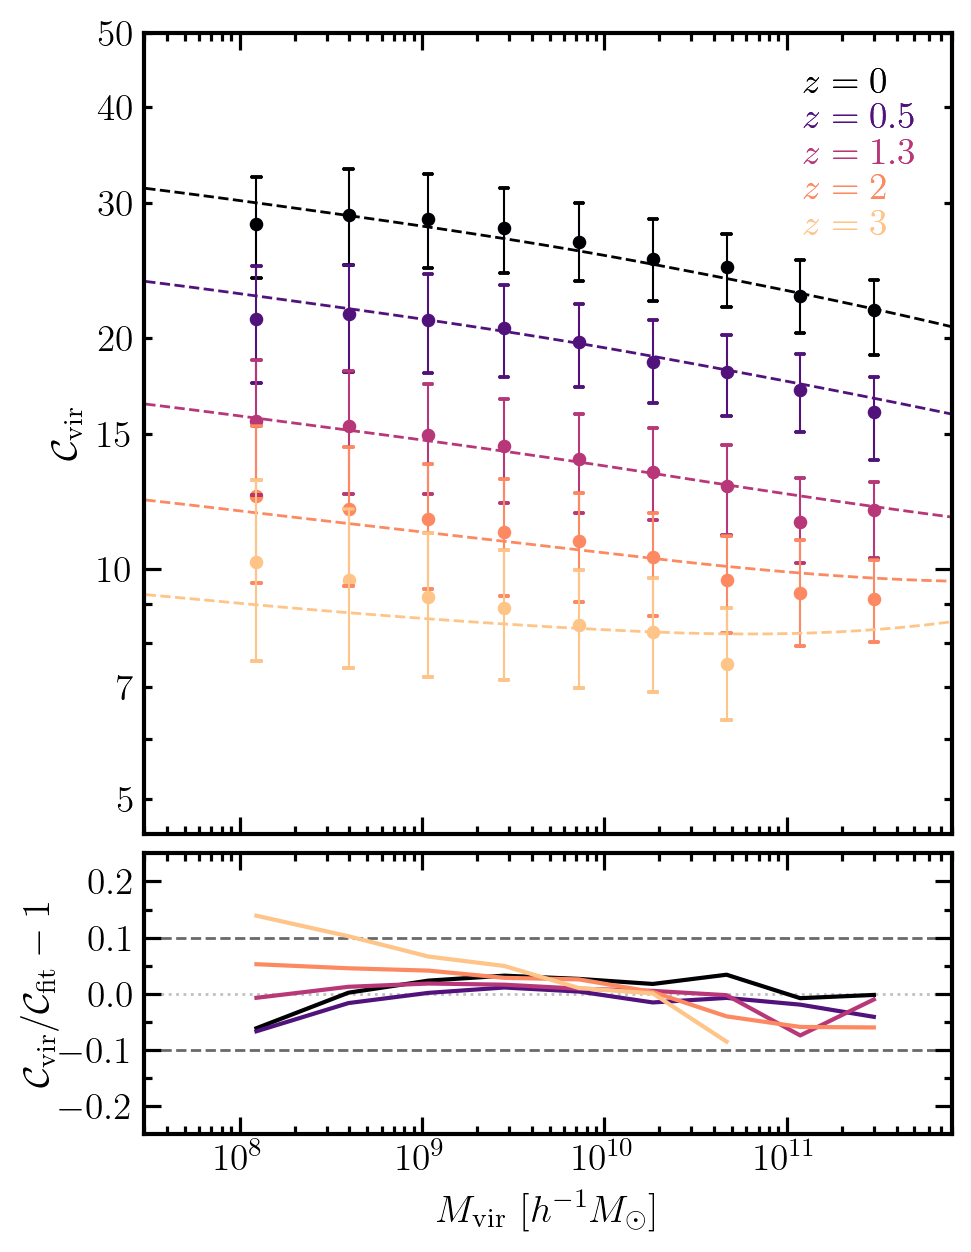

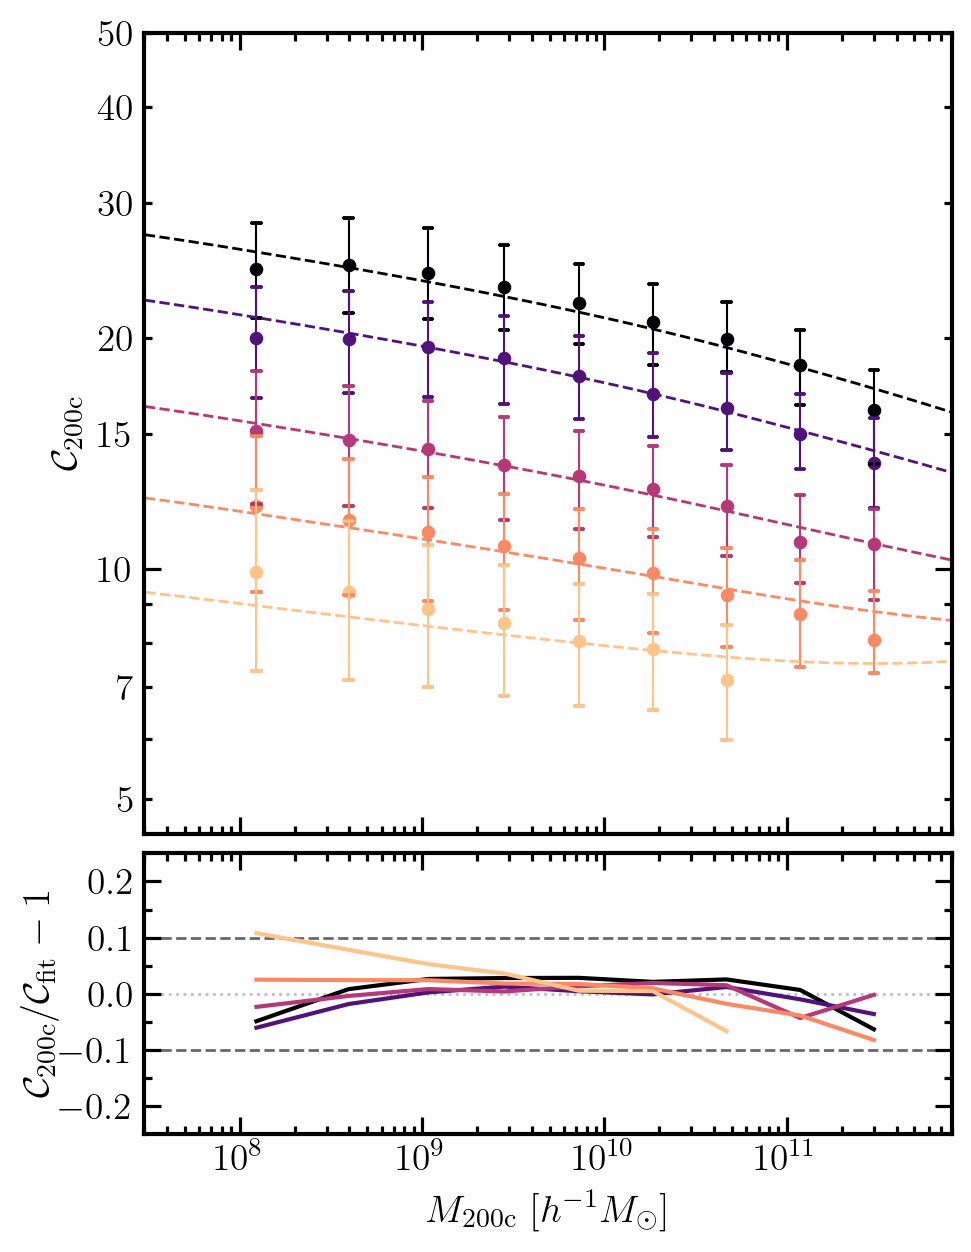

In [44]:
dja =  DJ19(model='lazar')

# overdensity models to fit over
mdefs = ['vir', '200c']
for mdef in mdefs:
    fig, axs = plt.subplots(figsize=(6.25/1.2, 8.75/1.2),
                           nrows=2, ncols=1, 
                           gridspec_kw={'height_ratios': [1, 0.35,]},
                           dpi=100)
    plt.subplots_adjust(wspace=0.1, hspace=0.035)
    
    # -----------------------------------------------------------------------------------------

    axs[0].xaxis.set_tick_params(direction='in', which='both'); axs[0].yaxis.set_tick_params(direction='in', which='both')
    axs[0].xaxis.set_ticks_position('both'); axs[0].yaxis.set_ticks_position('both')
    axs[0].set_xlabel(r'$M_{\rm %s}\ [h^{-1}M_{\odot}]$' % (mdef)); 
    axs[0].set_ylabel(r'$\mathcal{C}_{\rm %s}$' % (mdef))
    axs[0].set_xscale('log'); axs[0].set_yscale('log');
    axs[0].set_xlim(3e7, 8e11); axs[0].set_ylim(4.5,50)
    axs[0].set_xticklabels([])

    axs[0].set_yticks([5,6,7,8,9,15,20,30,40,50],minor=True)
    axs[0].set_yticklabels([r'$5$','',r'$7$','','',r'$15$',r'$20$',r'$30$',r'$40$','$50$'], fontsize=13.5,minor=True)
    axs[0].set_yticks([10])
    axs[0].set_yticklabels([r'$10$'], fontsize=13.5)
    
    axs[1].xaxis.set_tick_params(direction='in', which='both'); axs[1].yaxis.set_tick_params(direction='in', which='both')
    axs[1].xaxis.set_ticks_position('both'); axs[1].yaxis.set_ticks_position('both')
    axs[1].set_xlabel(r'$M_{\rm %s}\ [h^{-1}M_{\odot}]$' % (mdef)); 
    axs[1].set_ylabel(r'$\mathcal{C}_{\rm %s}/\mathcal{C}_{\rm fit} - 1$' % (mdef), labelpad=-0.0)
    axs[1].set_xscale('log'); axs[1].set_yscale('linear');
    axs[1].set_xlim(3e7,8e11); axs[1].set_ylim(-0.25,0.25)

    major_ticks = np.array([-0.2, -0.1, 0, 0.1, 0.2]) #np.arange(-0.4, 0.4, 5)
    minor_ticks = np.array([-0.15, -0.05, 0.05, 0.15]) #np.arange(0, 101, 5)
    axs[1].set_yticks(major_ticks)
    axs[1].set_yticks(minor_ticks, minor=True)
    
    # -----------------------------------------------------------------------------------------

    cmap = matplotlib.cm.get_cmap('magma')
    color0=cmap(0.0)
    color05=cmap(0.25)
    color1=cmap(0.5)
    color2=cmap(0.75)
    color3=cmap(0.875)
    
    if mdef == 'vir':
        from matplotlib.patches import Rectangle
        empty = Rectangle((0,0), 0, 0, alpha=0.0)
        sim_leg = axs[0].legend([empty]*7,
                        [r'$z = 0$',
                        r'$z = 0.5$',
                        r'$z = 1.3$',
                        r'$z = 2$',
                        r'$z = 3$'],
                       loc="upper right",frameon=False,ncol=1,
                       fontsize=13.5,handlelength=0,handletextpad=0,labelspacing=0.05)
        sim_leg.get_texts()[0].set_color(color0)
        sim_leg.get_texts()[1].set_color(color05)
        sim_leg.get_texts()[2].set_color(color1)
        sim_leg.get_texts()[3].set_color(color2)
        sim_leg.get_texts()[4].set_color(color3)
        axs[0].add_artist(sim_leg)
        
    # -----------------------------------------------------------------------------------------
    
    m_arr = 10**np.linspace(6.0, 12.0)
    if mdef == 'vir':
        params = [5.61498433e-01, 5.82703348e-01, 1.09266367e+01, 8.21546911e-02, 1.38014433e+02, 6.97727752e-03]
    elif mdef == '200c':
        params = [6.77559080e-02, 8.22941835e-02, 1.29431121e+02, 1.41034338e-02, 1.28496872e+03, 3.17961765e-01]
        
    def func(x, z, params):
        return dja.function(x, z, params[0], params[1], params[2], params[3], params[4], params[5])
    
    # call all concentration relation data for each characteristic redshift 
    for ind, zref in enumerate(dja.list_avail_redshifts()):
        # load relavent parameters
        proj_res = dja.concatenate_proj_results(mdef=mdef)[zref]  
        xdata, ydata = proj_res['mass']*h0, proj_res['C.1']
        mask = (mmin < xdata) & (xdata < mmax)
            
        # median conc-mass relation
        stats = dja.get_statistics(xdata=xdata[mask], ydata=ydata[mask],
                                  nbins=10, 
                                  xbound=(7e7, 3e11),
                                  clean_up=True)
        if zref == 'z3.000':
            mask = stats['x.bins'] < 5e10
            for skey, sval in stats.items():
                stats[skey] = sval[mask] 
        
        # axs[0] plots main fit results
        color = dja.color_ref_by_redshift()[zref]
        dja.plot_stats_scatter(stats=stats, axs=axs[0], color=color)
        
        # plot resulting fits
        yfit = func(x=m_arr, z=np.float64(zref[1:]), params=params)
        axs[0].plot(m_arr, yfit, color=color, ls='--', lw=1.0)
                    
        # plot residuals
        yfit_data = func(x=stats['x.bins'], z=np.float64(zref[1:]), params=params)
        residual = stats['y.median']/yfit_data - 1.0
        axs[1].plot(stats['x.bins'], residual, ls='-', lw=1.5, color=color)

    axs[1].plot(m_arr, np.linspace(0.0, 0.0), color='silver', lw=1.0, ls=':', zorder=0)
    axs[1].plot(m_arr, np.linspace(0.1, 0.1), color='dimgray', lw=1.0, ls='--', zorder=0)
    axs[1].plot(m_arr, np.linspace(-0.1, -0.1), color='dimgray', lw=1.0, ls='--', zorder=0)

---
# Scatter of projected concentration $\mathcal{C}_{\Delta}$

Projected concentrations are expected to follow a log-normal distribution:
\begin{align}
    P(\mathcal{C})
    &=
    \frac{\left( \mathcal{C}\, \log 10 \right)^{-1}}{\sqrt{2\pi}\, \sigma_{\log_{10}\mathcal{C}} }
    \exp \left[ - \frac{\left( \log_{10}\mathcal{C} - \log_{10}\mathcal{C}_{0} \right)^{2}}{2\sigma_{\log_{10}\mathcal{C}}^{2}} \right]
    \, ,
\end{align}

In [536]:
class LogNormal(object):
    def function(self, logx: float, logm: float, sigma: float) -> float:
        norm_inv = 10**logx * np.log(10.0) * sigma * np.sqrt(2.0 * np.pi) 
        exp_term = - (logx - logm)**2 / (2.0 * sigma**2)
        return 1.0 / norm_inv * np.exp(exp_term)
    
    def plot_density(self, path, zref, color):
    h5 = h5py.File(path, 'r')
    mass = np.concatenate((h5[mass_def][:], h5[mass_def][:], h5[mass_def][:])) * h0
    conc = np.concatenate((h5[conc_def[0]][:], h5[conc_def[1]][:], h5[conc_def[2]][:]))
    h5.close()
    
    mask = (1e8 < mass) & (mass < 1e10)
    
    cfit = 10.**log10c(np.log10(mass[mask]), fvir_dict[zref][0], fvir_dict[zref][1])

0.029368575624082235
